# Setting

## Libraries

In [1]:
library(quantmod)
library(forecast)
library(rugarch)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [2]:
library(prophet)
library(dplyr)

library(bsts)

library(xgboost)

Loading required package: Rcpp

Loading required package: rlang


Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: BoomSpikeSlab

Loading required package: Boom

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘Boom’


The following object is masked from ‘package:stats’:

    rWishart



Attaching package: ‘BoomSpikeSlab’


The following object is masked from ‘package:stats’:

    knots



Attaching package: ‘bsts’


The following object is masked from ‘package:BoomSpikeSlab’:

    SuggestBurn



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




### user's defined

In [3]:
path <- '~/works/utils/r'
source(paste(path, "myutils.r", sep='/'))
source(paste(path, "myarimagarch.r", sep='/'))

In [4]:
new.get_result <- function(x, group, group.col='Models',
                          errors=c('rmse','mape') # unconditional forecast
                          #errors=c('rmse.mean','mape.mean') # daily forecast
                          ) {
    y <- my.get_result(x, group, errors=errors, group.col=group.col)
    colnames(y) <- c('rmse','mape',group.col)
    return(y)
}


new.plot_errors <- function(x, group.col='Models', ...) {
    my.plot_errors(x, metrics=c('rmse'), group.col=group.col, ...)
}

# forecast only at h
new.forecast <- function(x, h, forecastfunction, ...) {
    fc <- forecastfunction(x, h, ...)
    fc <- list(method = paste("Forecasting on", h, sep=' '), mean=fc$mean[h])
}

## Data

### S&P 500

In [5]:
train_start <- '1991-01-01'
train_end <- '2019-12-31'

test_start <- '2020-01-01'
test_end <- '2020-12-31'

In [6]:
from <- train_start
to <- test_end
getSymbols("^GSPC", from=from, to=to)

[1] "^GSPC"

In [7]:
spx <- GSPC
colnames(spx) <- c('o','h','l','c','v','a')

### Return

In [8]:
lookahead <- 21

In [9]:
spx.ret <- diff(log(spx$a), lookahead)
spx.ret <- na.omit(spx.ret)
colnames(spx.ret) <- 'logret'
head(spx.ret)

               logret
1991-01-31 0.05216129
1991-02-01 0.06360416
1991-02-04 0.08173788
1991-02-05 0.10755822
1991-02-06 0.12847341
1991-02-07 0.13502311

In [10]:
train <- window(spx.ret, end=as.Date(train_end))
test <- window(spx.ret, start=as.Date(test_start), end=as.Date(test_end))

## CV Settings

In [11]:
YEAR <- 252

#hori <- floor(YEAR/2)
#hori <- floor(YEAR/6)
hori <- floor(YEAR/12)

#peri <- floor(hori/2)
#peri <- hori*2
peri <- hori

#wind <- 5*YEAR
#wind <- 7*YEAR
wind <- 9*YEAR

### testing
- rerun Regressors

In [12]:
testing <- FALSE

if (testing) {
    train_start <- '1991-01-01'

    #train_end <- '2000-12-31'
    train_end <- '2000-07-01'
    #train_end <- '1997-12-31'
    
    train <- window(spx.ret, start=as.Date(train_start), end=as.Date(train_end))
}

In [13]:
n <- (nrow(train) - wind - hori)/floor(peri)
print(paste('number of iterations: ', round(n), sep=''))

[1] "number of iterations: 238"


## Regressors

In [15]:
x <- RSI(spx$a)
trainx <- merge(train, x, join='left', fill=NA)

In [16]:
# use close instead of adjusted to make consistent with "un-adjusted" high & low
x <- BBands(spx[,c('h','l','c')])
x <- x$pctB
trainx <- merge(trainx, x, join='left', fill=NA)

In [17]:
x <- MACD(spx$a)
x <- x$macd - x$signal
trainx <- merge(trainx, x, join='left', fill=NA)

In [18]:
colnames(trainx) <- c('y','rsi','bbands','macd')
trainx <- na.omit(trainx)
head(trainx)
tail(trainx)

                    y      rsi    bbands        macd
1991-02-19 0.10602550 72.59254 0.8419486 -0.03641515
1991-02-20 0.09798126 66.25313 0.7706927 -0.18551057
1991-02-21 0.10585688 66.00481 0.7330987 -0.30953562
1991-02-22 0.10194779 66.54491 0.7402938 -0.39546732
1991-02-25 0.09259647 67.84742 0.7305630 -0.43573971
1991-02-26 0.07655978 60.80133 0.6379610 -0.55105032

                    y      rsi    bbands       macd
2019-12-23 0.03808252 76.15462 0.9680588 0.15430304
2019-12-24 0.03571448 75.83204 0.9028770 0.14089335
2019-12-26 0.03335029 78.41506 0.9189083 0.14916039
2019-12-27 0.03119111 78.43159 0.8946206 0.13732115
2019-12-30 0.02122778 68.77901 0.7837726 0.07574999
2019-12-31 0.02818876 70.74366 0.7500170 0.04243151

# Prophet

## Setting

In [17]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL) {
    
    check.ds <- function(x) {
        d <- try(as.POSIXct(x$ds, format = "%Y-%m-%d"), silent=T)
        if ((sum(is.na(d))>0) | (is.element("try-error", class(d))))  {
            #print("That wasn't correct!")
            x$ds <- seq(as.Date('1901-01-01'), length.out=length(x$ds), by=1)
        }
        return(x)
    }
    
    model <- prophet()

    if (!is.null(xreg)) {
        ### convert data for prophet
        #x <- ifelse(is.null(dim(x)), data.frame(x), x) # not works
        if (is.null(dim(x))) {x <- data.frame(x)}
        colnames(x) <- 'y'
        x.train <- cbind(x, xreg)
        x.train <- as.data.frame(x.train)
        x.train <- cbind(ds=rownames(x.train), x.train)
        rownames(x.train) <- NULL
        x.train <- check.ds(x.train)

        ### add regressors before fitting
        for (c in colnames(xreg)) {
            model <- add_regressor(model, c)
        }

        ### fit: must run after add_regressor and before make_future_dataframe
        model <- fit.prophet(model, x.train)

        ### prepare future ds
        future <- make_future_dataframe(model, periods=h)

        # regessor assumption for future
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }

        # rbind history & future of xreg
        xreg.all <- data.frame(xreg)
        xreg.coln <- colnames(xreg.all) # save name for the case of single xreg

        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        
        # update future
        if ((dim(xreg.h)[2]==1) & (dim(xreg.h)[1]==length(xreg.coln))) {
            xreg.h <- t(xreg.h) # the case of h==1
        }
        colnames(xreg.h) <- xreg.coln # match name to rbind
        #xreg.all <- rbind(xreg.all, xreg.h)
        xreg.all <- rbind(as.matrix(xreg.all), xreg.h) 
        xreg.all <- data.frame(xreg.all, row.names = NULL) 
        xreg.all$ds <- future$ds
        future <- xreg.all

    } else {
        x.train <- data.frame(ds=index(x), y=as.numeric(x))
        x.train <- check.ds(x.train)
        model <- fit.prophet(model, x.train)
        future <- make_future_dataframe(model, periods=h)
    }

    fc <- predict(model, future)
    fc <- list(method = "Prophet Forecasting", mean=tail(fc$yhat, h),
               model=model, pred=fc) # save model & pred result as well
    return(fc)
} 

prophet.forecast <- cv.forecast

In [18]:
cv.forecast.2 <- function(x, h, ...) {
    new.forecast(x, h, cv.forecast, ...)
}

## Basic

In [20]:
result.m01.1 <- my.tsCV(train, cv.forecast.2, h=hori, window=wind, step=peri,
                        silent=F)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

In [21]:
x <- result.m01.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Additional regressors

In [22]:
result.m01.2 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                          xreg=trainx[,2:4],
                          silent=F)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

In [23]:
result.m01.3 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                          xreg=trainx[,3], 
                          silent=F)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

In [24]:
result.m01.4 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                         xreg=trainx[,2:4],
                         xreg.msize=hori)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

## Compare Errors

In [25]:
my.figsize(10,6)

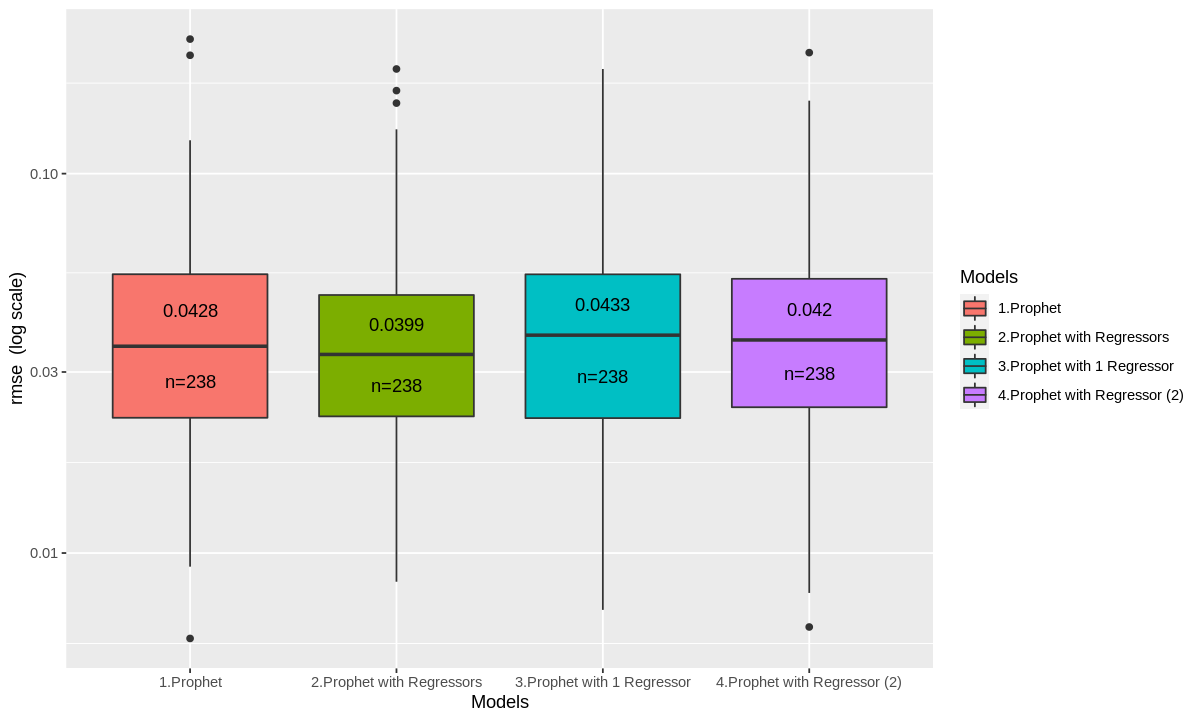

In [26]:
errors.1 <- new.get_result(result.m01.1, '1.Prophet')
errors.2 <- new.get_result(result.m01.2, '2.Prophet with Regressors')
errors.3 <- new.get_result(result.m01.3, '3.Prophet with 1 Regressor')
errors.4 <- new.get_result(result.m01.4, '4.Prophet with Regressor (2)')

x <- errors.1
x <- rbind(x, errors.2)
x <- rbind(x, errors.3)
x <- rbind(x, errors.4)
new.plot_errors(x, ylog=T)

### save result

In [27]:
x <- result.m01.1
write.csv(x, file = "prophet_result_m0101.csv")
x <- result.m01.2
write.csv(x, file = "prophet_result_m0102.csv")
x <- result.m01.3
write.csv(x, file = "prophet_result_m0103.csv")
x <- result.m01.4
write.csv(x, file = "prophet_result_m0104.csv")

### load result

In [17]:
result.m01.1 <- read.csv(file = 'prophet_result_m0101.csv')
result.m01.2 <- read.csv(file = 'prophet_result_m0102.csv')
result.m01.3 <- read.csv(file = 'prophet_result_m0103.csv')
result.m01.4 <- read.csv(file = 'prophet_result_m0104.csv')

In [74]:
result.m01 <- result.m01.2

# BSTS

## Setting

In [92]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL, expected.model.size=0,
                        model=NULL, niter=1000, ...) 
{
    if (!is.null(xreg)) {
        ### set params for fitting
        # organize data for fitting
        if (is.null(dim(x))) {x <- data.frame(x)}
        colnames(x) <- 'y'
        x.train <- cbind(x, xreg)
        x.train <- as.data.frame(x.train)
        
        if (is.null(model)) {
            n <- ncol(x.train)
            if ((expected.model.size < 1) | (expected.model.size > n)) {
                expected.model.size <- n
            }
            ss <- AddSemilocalLinearTrend(list(), x.train$y)
            model <- bsts(y ~ .,
                          state.specification = ss,
                          niter = niter,
                          data = x.train,
                          expected.model.size = expected.model.size)  # Passed to SpikeSlabPrior.
            olddata <- NULL
        } else {
            olddata <- x.train
        }
        
        ### set params for prediction
        # regessor assumption for future
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }

        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }

        xreg.all <- data.frame(xreg)
        xreg.coln <- colnames(xreg.all) # save name for the case of single xreg
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        
        if ((dim(xreg.h)[2]==1) & (dim(xreg.h)[1]==length(xreg.coln))) {
            xreg.h <- t(xreg.h) # the case of h==1
        } else {
            xreg.h <- as.ts(xreg.h) # convert to ts as xreg is ts
        }
        
        colnames(xreg.h) <- xreg.coln # match name to rbind
        
    } else {
        if (is.null(model)) {
            ss <- AddSemilocalLinearTrend(list(), x)
            model <- bsts(x, state.specification = ss, niter=niter, ...)
            olddata <- NULL
        } else {
            olddata <- x
        }
        xreg.h <- NULL
    }
    # predict
    fc <- predict(model, horizon=h, newdata=xreg.h, olddata=olddata)
    fc$model <- model
    return(fc)
}

bsts.forecast <- cv.forecast

In [29]:
cv.forecast.2 <- function(x, h, ...) {
    new.forecast(x, h, cv.forecast, ping=0, ...)
}

## Basic

In [30]:
result.m02.1 <- my.tsCV(train, cv.forecast.2, h=hori, window=wind, step=peri)

10 % done.

20 % done.

30 % done.

40 % done.

50 % done.

60 % done.

70 % done.

80 % done.

90 % done.



In [31]:
x <- result.m02.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Regression with spike and slab priors

In [32]:
result.m02.2 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        xreg=trainx[,2:4], 
                        silent=F)

=-=-=-=-= Iteration 0 Mon Sep 26 23:50:48 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Sep 26 23:50:51 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Sep 26 23:50:55 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Sep 26 23:50:58 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Sep 26 23:51:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Sep 26 23:51:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Sep 26 23:51:09 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Mon Sep 26 23:51:13 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Mon Sep 26 23:51:17 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Mon Sep 26 23:51:20 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Mon Sep 26 23:51:24 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Sep 26 23:51:28 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Sep 26 23:51:32 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Sep 26 23:51:35 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Sep 26 23:51:39 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Sep 26 23:51:42 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Sep 26 23:51:46 2022 =-=-=-=-=
=

10 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 00:05:19 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 00:05:22 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 00:05:26 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 00:05:29 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 00:05:33 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 00:05:37 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 00:05:40 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 00:05:44 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 00:05:47 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 00:05:51 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 00:05:55 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 00:05:58 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 00:06:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 00:06:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 00:06:09 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 00:06:13 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 00:06:16 2022 =-=-=-=-=
=

20 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 00:19:47 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 00:19:50 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 00:19:54 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 00:19:57 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 00:20:01 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 00:20:04 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 00:20:08 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 00:20:11 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 00:20:15 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 00:20:19 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 00:20:23 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 00:20:26 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 00:20:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 00:20:33 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 00:20:37 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 00:20:41 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 00:20:44 2022 =-=-=-=-=
=

30 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 00:34:15 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 00:34:19 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 00:34:22 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 00:34:26 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 00:34:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 00:34:33 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 00:34:37 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 00:34:40 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 00:34:44 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 00:34:47 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 00:34:51 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 00:34:55 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 00:34:58 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 00:35:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 00:35:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 00:35:09 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 00:35:13 2022 =-=-=-=-=
=

40 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 00:48:42 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 00:48:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 00:48:49 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 00:48:52 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 00:48:56 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 00:48:59 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 00:49:03 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 00:49:07 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 00:49:10 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 00:49:14 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 00:49:18 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 00:49:21 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 00:49:25 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 00:49:28 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 00:49:32 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 00:49:35 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 00:49:39 2022 =-=-=-=-=
=

50 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 01:03:09 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 01:03:13 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 01:03:16 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 01:03:20 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 01:03:23 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 01:03:27 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 01:03:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 01:03:34 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 01:03:37 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 01:03:41 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 01:03:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 01:03:48 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 01:03:52 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 01:03:56 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 01:03:59 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 01:04:03 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 01:04:06 2022 =-=-=-=-=
=

60 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 01:17:38 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 01:17:41 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 01:17:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 01:17:48 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 01:17:52 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 01:17:55 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 01:17:59 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 01:18:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 01:18:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 01:18:10 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 01:18:14 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 01:18:18 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 01:18:21 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 01:18:25 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 01:18:28 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 01:18:32 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 01:18:35 2022 =-=-=-=-=
=

70 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 01:32:05 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 01:32:08 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 01:32:12 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 01:32:16 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 01:32:19 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 01:32:23 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 01:32:26 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 01:32:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 01:32:33 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 01:32:37 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 01:32:41 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 01:32:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 01:32:48 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 01:32:52 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 01:32:56 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 01:32:59 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 01:33:03 2022 =-=-=-=-=
=

80 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 01:46:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 01:46:34 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 01:46:37 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 01:46:41 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 01:46:44 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 01:46:48 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 01:46:51 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 01:46:55 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 01:46:59 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 01:47:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 01:47:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 01:47:10 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 01:47:13 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 01:47:17 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 01:47:20 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 01:47:24 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 01:47:28 2022 =-=-=-=-=
=

90 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 02:00:56 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 02:01:00 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 02:01:03 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 02:01:07 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 02:01:10 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 02:01:14 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 02:01:17 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 02:01:21 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 02:01:25 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 02:01:28 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 02:01:32 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 02:01:36 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 02:01:39 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 02:01:43 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 02:01:46 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 02:01:50 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 02:01:54 2022 =-=-=-=-=
=

In [33]:
x <- result.m02.2
from <- x[!is.na(x[,'forecast_start']),][,1][1]
from <- index(trainx[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-02-09"


In [34]:
result.m02.3 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        xreg=trainx[,2:4], silent=F,
                        xreg.msize=hori)

=-=-=-=-= Iteration 0 Tue Sep 27 02:14:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 02:14:49 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 02:14:52 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 02:14:56 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 02:14:59 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 02:15:03 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 02:15:07 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 02:15:10 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 02:15:14 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 02:15:17 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 02:15:21 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 02:15:25 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 02:15:28 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 02:15:32 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 02:15:36 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 02:15:39 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 02:15:43 2022 =-=-=-=-=
=

10 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 02:29:11 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 02:29:15 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 02:29:18 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 02:29:22 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 02:29:25 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 02:29:29 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 02:29:32 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 02:29:36 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 02:29:39 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 02:29:43 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 02:29:47 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 02:29:50 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 02:29:54 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 02:29:57 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 02:30:01 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 02:30:04 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 02:30:08 2022 =-=-=-=-=
=

20 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 02:43:36 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 02:43:40 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 02:43:43 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 02:43:47 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 02:43:50 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 02:43:54 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 02:43:58 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 02:44:01 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 02:44:05 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 02:44:08 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 02:44:13 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 02:44:16 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 02:44:20 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 02:44:23 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 02:44:27 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 02:44:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 02:44:34 2022 =-=-=-=-=
=

30 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 02:58:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 02:58:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 02:58:09 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 02:58:13 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 02:58:16 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 02:58:20 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 02:58:23 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 02:58:27 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 02:58:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 02:58:34 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 02:58:38 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 02:58:41 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 02:58:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 02:58:49 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 02:58:52 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 02:58:56 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 02:58:59 2022 =-=-=-=-=
=

40 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 03:12:28 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 03:12:32 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 03:12:36 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 03:12:39 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 03:12:43 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 03:12:46 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 03:12:50 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 03:12:54 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 03:12:57 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 03:13:01 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 03:13:05 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 03:13:08 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 03:13:12 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 03:13:16 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 03:13:19 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 03:13:23 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 03:13:27 2022 =-=-=-=-=
=

50 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 03:26:56 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 03:26:59 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 03:27:03 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 03:27:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 03:27:10 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 03:27:14 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 03:27:17 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 03:27:21 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 03:27:24 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 03:27:28 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 03:27:32 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 03:27:35 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 03:27:39 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 03:27:42 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 03:27:46 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 03:27:49 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 03:27:53 2022 =-=-=-=-=
=

60 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 03:41:23 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 03:41:26 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 03:41:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 03:41:33 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 03:41:37 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 03:41:41 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 03:41:44 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 03:41:48 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 03:41:51 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 03:41:55 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 03:41:59 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 03:42:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 03:42:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 03:42:09 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 03:42:13 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 03:42:17 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 03:42:20 2022 =-=-=-=-=
=

70 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 03:55:51 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 03:55:54 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 03:55:58 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 03:56:01 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 03:56:05 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 03:56:08 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 03:56:12 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 03:56:16 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 03:56:19 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 03:56:23 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 03:56:27 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 03:56:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 03:56:34 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 03:56:37 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 03:56:41 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 03:56:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 03:56:48 2022 =-=-=-=-=
=

80 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 04:10:16 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 04:10:19 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 04:10:23 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 04:10:26 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 04:10:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 04:10:33 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 04:10:37 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 04:10:40 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 04:10:44 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 04:10:48 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 04:10:51 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 04:10:55 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 04:10:59 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 04:11:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 04:11:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 04:11:09 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 04:11:13 2022 =-=-=-=-=
=

90 % done.



=-=-=-=-= Iteration 0 Tue Sep 27 04:24:43 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 04:24:46 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 04:24:50 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 04:24:53 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 04:24:57 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 04:25:00 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 04:25:04 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Sep 27 04:25:07 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Sep 27 04:25:11 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Sep 27 04:25:15 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Sep 27 04:25:19 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Sep 27 04:25:22 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Sep 27 04:25:26 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Sep 27 04:25:29 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Sep 27 04:25:33 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Sep 27 04:25:36 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Sep 27 04:25:40 2022 =-=-=-=-=
=

## Compare Errors

In [35]:
my.figsize(10,6)

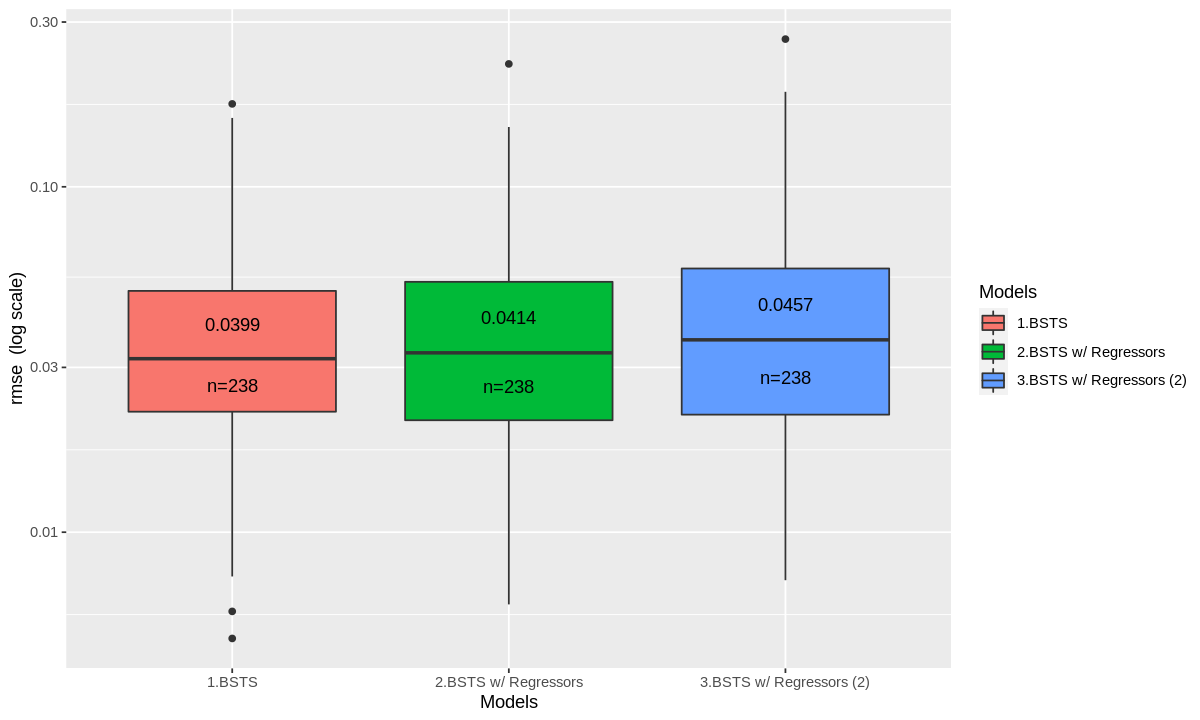

In [36]:
errors.1 <- new.get_result(result.m02.1, '1.BSTS')
errors.2 <- new.get_result(result.m02.2, '2.BSTS w/ Regressors')
errors.3 <- new.get_result(result.m02.3, '3.BSTS w/ Regressors (2)')

#x <- errors.1
x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)

new.plot_errors(x, ylog=T)

In [75]:
result.m02 <- result.m02.1

### save result

In [37]:
x <- result.m02.1
write.csv(x, file = "bsts_result_m0201.csv")
x <- result.m02.2
write.csv(x, file = "bsts_result_m0202.csv")
x <- result.m02.3
write.csv(x, file = "bsts_result_m0203.csv")

### load result

In [22]:
result.m02.1 <- read.csv(file = 'bsts_result_m0201.csv')
result.m02.2 <- read.csv(file = 'bsts_result_m0202.csv')
result.m02.3 <- read.csv(file = 'bsts_result_m0203.csv')

# ARIMA

## Setting

In [90]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL, order=NULL) {
    
    if (!is.null(xreg)) {
        
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }
        
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        #colnames(xreg.h) <- colnames(xreg) # error with multiple xreg
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        
        ## added for single day forecast
        xreg.coln <- colnames(xreg)
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        if ((dim(xreg.h)[2]==1) & (dim(xreg.h)[1]==length(xreg.coln))) {
            xreg.h <- t(xreg.h) # the case of h==1
        } else {
            xreg.h <- as.ts(xreg.h) # convert to ts as xreg is ts
        }
        
    } else {
        xreg.h <- NULL
    }
    if (is.null(order)) {
        fc <- forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                                  xreg=xreg, 
                                  #lambda="auto" # not for negative value
                                  ), h=h, xreg=xreg.h)
    } else {
        fc <- forecast(Arima(x, order=order, seasonal=FALSE, 
                                  xreg=xreg, 
                                  ), h=h, xreg=xreg.h)
    }
    return(fc)
}

arima.forecast <- cv.forecast

In [39]:
cv.forecast.2 <- function(x, h, ...) {
    new.forecast(x, h, cv.forecast, ...)
}

## Basic

In [40]:
result.m03.1 <- my.tsCV(train, cv.forecast.2, h=hori, window=wind, step=peri, 
                        silent=T)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : -8729.901
 ARIMA(1,0,0) with non-zero mean : -13486.9
 ARIMA(0,0,1) with non-zero mean : -10820.55
 ARIMA(0,0,0) with zero mean     : -8407.697
 ARIMA(2,0,0) with non-zero mean : -13491.63
 ARIMA(3,0,0) with non-zero mean : -13491.75
 ARIMA(4,0,0) with non-zero mean : -13496.44
 ARIMA(5,0,0) with non-zero mean : -13502.01
 ARIMA(5,0,1) with non-zero mean : -13509.96
 ARIMA(4,0,1) with non-zero mean : -13504.29
 ARIMA(5,0,2) with non-zero mean : -13507.99
 ARIMA(4,0,2) with non-zero mean : -13508.66
 ARIMA(5,0,1) with zero mean     : -13497.02

 Now re-fitting the best model(s) without approximations...

 ARIMA(5,0,1) with non-zero mean : -13497.21

 Best model: ARIMA(5,0,1) with non-zero mean 


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : -13377.54
 ARIMA(1,1,0) wi

10 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : -12619.17
 ARIMA(1,1,0) with drift         : -12616.45
 ARIMA(0,1,1) with drift         : -12617.47
 ARIMA(0,1,0)                    : -12621.17
 ARIMA(1,1,1) with drift         : -12615.73

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,0)                    : -12629.58

 Best model: ARIMA(0,1,0)                    


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : -12599.68
 ARIMA(1,1,0) with drift         : -12597.63
 ARIMA(0,1,1) with drift         : -12597.91
 ARIMA(0,1,0)                    : -12601.68
 ARIMA(1,1,1) with drift         : -12597.04

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,0)                    : -12610.08

 Best model: ARIMA(0,1,0)                    


 Fitting models using approximations to

20 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : -12017.38
 ARIMA(1,1,0) with drift         : -12014.64
 ARIMA(0,1,1) with drift         : -12015.43
 ARIMA(0,1,0)                    : -12019.38
 ARIMA(1,1,1) with drift         : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,0)                    : -12027.53

 Best model: ARIMA(0,1,0)                    


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : -12013.54
 ARIMA(1,1,0) with drift         : -12010.62
 ARIMA(0,1,1) with drift         : -12011.59
 ARIMA(0,1,0)                    : -12015.55
 ARIMA(1,1,1) with drift         : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,0)                    : -12023.69

 Best model: ARIMA(0,1,0)                    


 Fitting models using approximations to speed thing

30 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : -12023.7
 ARIMA(0,1,0) with drift         : -12005.68
 ARIMA(1,1,0) with drift         : -12003.47
 ARIMA(0,1,1) with drift         : -12003.75
 ARIMA(0,1,0)                    : -12007.68
 ARIMA(1,1,2) with drift         : -12005.34
 ARIMA(2,1,1) with drift         : -12003.68
 ARIMA(3,1,2) with drift         : -12015.1
 ARIMA(2,1,3) with drift         : -12015.95
 ARIMA(1,1,1) with drift         : -12032.52
 ARIMA(0,1,2) with drift         : -12004.11
 ARIMA(2,1,0) with drift         : -12003.5
 ARIMA(1,1,1)                    : -12034.31
 ARIMA(0,1,1)                    : -12005.76
 ARIMA(1,1,0)                    : -12005.48
 ARIMA(2,1,1)                    : -12005.7
 ARIMA(1,1,2)                    : -12035.81
 ARIMA(0,1,2)                    : -12006.11
 ARIMA(2,1,2)                    : -12025.67
 ARIMA(1,1,3)                    : -12006.67
 ARIMA(0,1,3)                    : -12007.7

40 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -12372.1
 ARIMA(0,0,0) with non-zero mean : -7638.056
 ARIMA(1,0,0) with non-zero mean : -12367.87
 ARIMA(0,0,1) with non-zero mean : -9696.992
 ARIMA(0,0,0) with zero mean     : -7638.917
 ARIMA(1,0,2) with non-zero mean : -12365.83
 ARIMA(2,0,1) with non-zero mean : -12370.39
 ARIMA(3,0,2) with non-zero mean : -12376.09
 ARIMA(3,0,1) with non-zero mean : -12376.91
 ARIMA(3,0,0) with non-zero mean : -12364.17
 ARIMA(4,0,1) with non-zero mean : -12371.52
 ARIMA(2,0,0) with non-zero mean : -12365.48
 ARIMA(4,0,0) with non-zero mean : -12363.21
 ARIMA(4,0,2) with non-zero mean : -12384.24
 ARIMA(5,0,2) with non-zero mean : Inf
 ARIMA(4,0,3) with non-zero mean : Inf
 ARIMA(3,0,3) with non-zero mean : Inf
 ARIMA(5,0,1) with non-zero mean : -12363.16
 ARIMA(5,0,3) with non-zero mean : -12358.93
 ARIMA(4,0,2) with zero mean     : -12386.23
 ARIMA(3,0,2) with zero mean     : -12377.81
 ARIMA(4,0,1)

50 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -11356.17
 ARIMA(0,0,0) with non-zero mean : -6690.499
 ARIMA(1,0,0) with non-zero mean : -11329.91
 ARIMA(0,0,1) with non-zero mean : -8719.031
 ARIMA(0,0,0) with zero mean     : -6690.897
 ARIMA(1,0,2) with non-zero mean : -11352.13
 ARIMA(2,0,1) with non-zero mean : Inf
 ARIMA(3,0,2) with non-zero mean : -11428.68
 ARIMA(3,0,1) with non-zero mean : -11362.48
 ARIMA(4,0,2) with non-zero mean : -11375.33
 ARIMA(3,0,3) with non-zero mean : -11375.66
 ARIMA(2,0,3) with non-zero mean : -11371.34
 ARIMA(4,0,1) with non-zero mean : -11374.63
 ARIMA(4,0,3) with non-zero mean : -11431.51
 ARIMA(5,0,3) with non-zero mean : Inf
 ARIMA(4,0,4) with non-zero mean : Inf
 ARIMA(3,0,4) with non-zero mean : Inf
 ARIMA(5,0,2) with non-zero mean : -11412.53
 ARIMA(5,0,4) with non-zero mean : Inf
 ARIMA(4,0,3) with zero mean     : -11433.45
 ARIMA(3,0,3) with zero mean     : -11377.55
 ARIMA(4,0,2) with zero 

60 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -11490.37
 ARIMA(0,0,0) with non-zero mean : -7047.452
 ARIMA(1,0,0) with non-zero mean : -11444.65
 ARIMA(0,0,1) with non-zero mean : -8991.749
 ARIMA(0,0,0) with zero mean     : -7039.512
 ARIMA(1,0,2) with non-zero mean : -11484.88
 ARIMA(2,0,1) with non-zero mean : -11485.48
 ARIMA(3,0,2) with non-zero mean : -11509.2
 ARIMA(3,0,1) with non-zero mean : -11496.02
 ARIMA(4,0,2) with non-zero mean : -11507.8
 ARIMA(3,0,3) with non-zero mean : -11507.44
 ARIMA(2,0,3) with non-zero mean : -11503.08
 ARIMA(4,0,1) with non-zero mean : -11507.8
 ARIMA(4,0,3) with non-zero mean : -11548.82
 ARIMA(5,0,3) with non-zero mean : -11539.74
 ARIMA(4,0,4) with non-zero mean : -11525.75
 ARIMA(3,0,4) with non-zero mean : -11542.99
 ARIMA(5,0,2) with non-zero mean : -11530.54
 ARIMA(5,0,4) with non-zero mean : -11540.45
 ARIMA(4,0,3) with zero mean     : -11550.67
 ARIMA(3,0,3) with zero mean     : -11509.

70 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : -11488.51
 ARIMA(0,1,0) with drift         : -11406.48
 ARIMA(1,1,0) with drift         : -11458.08
 ARIMA(0,1,1) with drift         : -11467.77
 ARIMA(0,1,0)                    : -11408.49
 ARIMA(1,1,2) with drift         : -11474.57
 ARIMA(2,1,1) with drift         : -11479.9
 ARIMA(3,1,2) with drift         : -11548.76
 ARIMA(3,1,1) with drift         : -11480.84
 ARIMA(4,1,2) with drift         : Inf
 ARIMA(3,1,3) with drift         : -11550.62
 ARIMA(2,1,3) with drift         : -11554.97
 ARIMA(1,1,3) with drift         : -11477.58
 ARIMA(2,1,4) with drift         : Inf
 ARIMA(1,1,4) with drift         : -11486.33
 ARIMA(3,1,4) with drift         : Inf
 ARIMA(2,1,3)                    : -11556.97
 ARIMA(1,1,3)                    : -11479.59
 ARIMA(2,1,2)                    : -11490.52
 ARIMA(3,1,3)                    : -11552.63
 ARIMA(2,1,4)                    : Inf
 ARIMA(1,1,2)      

80 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : -11396.17
 ARIMA(0,1,0) with drift         : -11328.02
 ARIMA(1,1,0) with drift         : -11371.4
 ARIMA(0,1,1) with drift         : -11379.49
 ARIMA(0,1,0)                    : -11330.02
 ARIMA(1,1,2) with drift         : -11385.91
 ARIMA(2,1,1) with drift         : -11389.47
 ARIMA(3,1,2) with drift         : -11458.66
 ARIMA(3,1,1) with drift         : -11388.42
 ARIMA(4,1,2) with drift         : Inf
 ARIMA(3,1,3) with drift         : Inf
 ARIMA(2,1,3) with drift         : -11458.39
 ARIMA(4,1,1) with drift         : -11391.51
 ARIMA(4,1,3) with drift         : Inf
 ARIMA(3,1,2)                    : -11460.67
 ARIMA(2,1,2)                    : -11398.17
 ARIMA(3,1,1)                    : -11390.41
 ARIMA(4,1,2)                    : Inf
 ARIMA(3,1,3)                    : Inf
 ARIMA(2,1,1)                    : -11391.47
 ARIMA(2,1,3)                    : -11460.41
 ARIMA(4,1,1)            

90 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -12838.17
 ARIMA(0,0,0) with non-zero mean : -8091.392
 ARIMA(1,0,0) with non-zero mean : -12837.14
 ARIMA(0,0,1) with non-zero mean : -10097.45
 ARIMA(0,0,0) with zero mean     : -7938.12
 ARIMA(1,0,2) with non-zero mean : -12838.32
 ARIMA(0,0,2) with non-zero mean : -11279.5
 ARIMA(1,0,1) with non-zero mean : -12837.52
 ARIMA(1,0,3) with non-zero mean : -12836.31
 ARIMA(0,0,3) with non-zero mean : -11685.67
 ARIMA(2,0,1) with non-zero mean : -12838.94
 ARIMA(2,0,0) with non-zero mean : -12838.65
 ARIMA(3,0,1) with non-zero mean : -12842.45
 ARIMA(3,0,0) with non-zero mean : -12841.35
 ARIMA(4,0,1) with non-zero mean : -12840.34
 ARIMA(3,0,2) with non-zero mean : Inf
 ARIMA(4,0,0) with non-zero mean : -12838.9
 ARIMA(4,0,2) with non-zero mean : -12861.04
 ARIMA(5,0,2) with non-zero mean : Inf
 ARIMA(4,0,3) with non-zero mean : -12898.44
 ARIMA(3,0,3) with non-zero mean : -12879.27
 ARIMA(5,

In [41]:
x <- result.m03.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Regression with ARIMA errors

In [42]:
result.m03.2 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                       silent=F,
                       xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -14728.24
 Regression with ARIMA(0,1,0) errors : -14705.76
 Regression with ARIMA(1,1,0) errors : -14703.21
 Regression with ARIMA(0,1,1) errors : -14703.85
 Regression with ARIMA(0,1,0) errors : -14707.74
 Regression with ARIMA(1,1,2) errors : -14755.07
 Regression with ARIMA(0,1,2) errors : -14703.58
 Regression with ARIMA(1,1,1) errors : -14701.2
 Regression with ARIMA(1,1,3) errors : -14756.2
 Regression with ARIMA(0,1,3) errors : -14715.69
 Regression with ARIMA(2,1,3) errors : -14743.68
 Regression with ARIMA(1,1,4) errors : -14754.84
 Regression with ARIMA(0,1,4) errors : -14713.96
 Regression with ARIMA(2,1,4) errors : -14742.53
 Regression with ARIMA(1,1,3) errors : -14757.92
 Regression with ARIMA(0,1,3) errors : -14717.66
 Regression with ARIMA(1,1,2) errors : -14756.77
 Regression with ARIMA(2,1,3) errors : -14745.4
 Regression with ARIMA(1,1,4) errors : -14756.51
 Regression

10 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -14057.56
 Regression with ARIMA(0,0,0) errors : -10451.94
 Regression with ARIMA(1,0,0) errors : -14055.02
 Regression with ARIMA(0,0,1) errors : -12212.26
 Regression with ARIMA(0,0,0) errors : -9125.585
 Regression with ARIMA(1,0,2) errors : -14059.61
 Regression with ARIMA(0,0,2) errors : -13092.48
 Regression with ARIMA(1,0,1) errors : -14061.59
 Regression with ARIMA(2,0,1) errors : -14058.81
 Regression with ARIMA(2,0,0) errors : -14060.82
 Regression with ARIMA(1,0,1) errors : -13926.65

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(1,0,1) errors : -14060.43

 Best model: Regression with ARIMA(1,0,1) errors 


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -14049.73
 Regression with ARIMA(0,0,0) errors : -10463.36
 Regression with ARIMA(1,0,0) errors : -14047.15
 Regression with ARIMA(0,0,1)

20 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : Inf
 Regression with ARIMA(0,1,0) errors : -13379.9
 Regression with ARIMA(1,1,0) errors : -13377.2
 Regression with ARIMA(0,1,1) errors : -13377.89
 Regression with ARIMA(0,1,0) errors : -13381.91
 Regression with ARIMA(1,1,1) errors : Inf

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(0,1,0) errors : -13390.66

 Best model: Regression with ARIMA(0,1,0) errors 


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : Inf
 Regression with ARIMA(0,1,0) errors : -13381.25
 Regression with ARIMA(1,1,0) errors : -13378.41
 Regression with ARIMA(0,1,1) errors : -13379.25
 Regression with ARIMA(0,1,0) errors : -13383.26
 Regression with ARIMA(1,1,1) errors : Inf

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(0,1,0) errors : -13392.01

 Best model: Regression with ARIMA(0,1,0)

30 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -13509.32
 Regression with ARIMA(0,0,0) errors : -10219.25
 Regression with ARIMA(1,0,0) errors : -13507.76
 Regression with ARIMA(0,0,1) errors : -11765.04
 Regression with ARIMA(0,0,0) errors : -8502.109
 Regression with ARIMA(1,0,2) errors : -13506.99
 Regression with ARIMA(2,0,1) errors : Inf
 Regression with ARIMA(3,0,2) errors : -13502.83
 Regression with ARIMA(2,0,3) errors : -13507.36
 Regression with ARIMA(1,0,1) errors : -13508.29
 Regression with ARIMA(1,0,3) errors : -13505.45
 Regression with ARIMA(3,0,1) errors : -13506.88
 Regression with ARIMA(3,0,3) errors : -13513.93
 Regression with ARIMA(4,0,3) errors : Inf
 Regression with ARIMA(3,0,4) errors : -13514.85
 Regression with ARIMA(2,0,4) errors : -13509.02
 Regression with ARIMA(4,0,4) errors : -13512.96
 Regression with ARIMA(3,0,5) errors : -13508.01
 Regression with ARIMA(2,0,5) errors : -13510.83
 Regression with ARI

40 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -13769.81
 Regression with ARIMA(0,0,0) errors : -10265.3
 Regression with ARIMA(1,0,0) errors : -13762.85
 Regression with ARIMA(0,0,1) errors : -11881.84
 Regression with ARIMA(0,0,0) errors : -8821.143
 Regression with ARIMA(1,0,2) errors : -13762.57
 Regression with ARIMA(2,0,1) errors : -13768.3
 Regression with ARIMA(3,0,2) errors : -13783.22
 Regression with ARIMA(3,0,1) errors : -13768.49
 Regression with ARIMA(4,0,2) errors : Inf
 Regression with ARIMA(3,0,3) errors : -13781.28
 Regression with ARIMA(2,0,3) errors : -13768.18
 Regression with ARIMA(4,0,1) errors : -13769.2
 Regression with ARIMA(4,0,3) errors : Inf
 Regression with ARIMA(3,0,2) errors : Inf

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(3,0,2) errors : -13777.69

 Best model: Regression with ARIMA(3,0,2) errors 


 Fitting models using approximations to speed things up...

 

50 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -12503.57
 Regression with ARIMA(0,0,0) errors : -8896.241
 Regression with ARIMA(1,0,0) errors : -12485.86
 Regression with ARIMA(0,0,1) errors : -10569.77
 Regression with ARIMA(0,0,0) errors : -7714.817
 Regression with ARIMA(1,0,2) errors : -12497.82
 Regression with ARIMA(2,0,1) errors : -12496.35
 Regression with ARIMA(3,0,2) errors : Inf
 Regression with ARIMA(2,0,3) errors : -12527.94
 Regression with ARIMA(1,0,3) errors : -12530.81
 Regression with ARIMA(0,0,3) errors : -11677.03
 Regression with ARIMA(1,0,4) errors : -12528.79
 Regression with ARIMA(0,0,2) errors : -11229.55
 Regression with ARIMA(0,0,4) errors : -12012.79
 Regression with ARIMA(2,0,4) errors : -12555.48
 Regression with ARIMA(3,0,4) errors : -12559.17
 Regression with ARIMA(3,0,3) errors : -12529.19
 Regression with ARIMA(4,0,4) errors : -12555.94
 Regression with ARIMA(3,0,5) errors : -12539.67
 Regression wi

60 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -12597.56
 Regression with ARIMA(0,0,0) errors : -9087.133
 Regression with ARIMA(1,0,0) errors : -12572.15
 Regression with ARIMA(0,0,1) errors : -10736.93
 Regression with ARIMA(0,0,0) errors : -8079.117
 Regression with ARIMA(1,0,2) errors : -12594.14
 Regression with ARIMA(2,0,1) errors : -12593.03
 Regression with ARIMA(3,0,2) errors : -12658.36
 Regression with ARIMA(3,0,1) errors : -12603.77
 Regression with ARIMA(4,0,2) errors : -12622.07
 Regression with ARIMA(3,0,3) errors : -12622.59
 Regression with ARIMA(2,0,3) errors : -12619.12
 Regression with ARIMA(4,0,1) errors : -12620.82
 Regression with ARIMA(4,0,3) errors : Inf
 Regression with ARIMA(3,0,2) errors : -12548.61

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(3,0,2) errors : -12655.81

 Best model: Regression with ARIMA(3,0,2) errors 


 Fitting models using approximations to speed 

70 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -12631.51
 Regression with ARIMA(0,0,0) errors : -9120.766
 Regression with ARIMA(1,0,0) errors : -12607
 Regression with ARIMA(0,0,1) errors : -10776.09
 Regression with ARIMA(0,0,0) errors : -8111.103
 Regression with ARIMA(1,0,2) errors : -12626.77
 Regression with ARIMA(2,0,1) errors : -12625.53
 Regression with ARIMA(3,0,2) errors : -12685.73
 Regression with ARIMA(3,0,1) errors : -12637.75
 Regression with ARIMA(4,0,2) errors : -12654.14
 Regression with ARIMA(3,0,3) errors : -12654.51
 Regression with ARIMA(2,0,3) errors : -12650.91
 Regression with ARIMA(4,0,1) errors : -12654.37
 Regression with ARIMA(4,0,3) errors : -12686.13
 Regression with ARIMA(5,0,3) errors : -12700.25
 Regression with ARIMA(5,0,2) errors : -12654.47
 Regression with ARIMA(5,0,4) errors : -12662.71
 Regression with ARIMA(4,0,4) errors : -12698.47
 Regression with ARIMA(5,0,3) errors : Inf

 Now re-fitting 

80 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -12550.88
 Regression with ARIMA(0,0,0) errors : -9082.974
 Regression with ARIMA(1,0,0) errors : -12530.87
 Regression with ARIMA(0,0,1) errors : -10726.19
 Regression with ARIMA(0,0,0) errors : -7990.949
 Regression with ARIMA(1,0,2) errors : -12547.22
 Regression with ARIMA(2,0,1) errors : -12546.03
 Regression with ARIMA(3,0,2) errors : -12611.03
 Regression with ARIMA(3,0,1) errors : -12556.14
 Regression with ARIMA(4,0,2) errors : -12573.38
 Regression with ARIMA(3,0,3) errors : -12573.93
 Regression with ARIMA(2,0,3) errors : -12570.37
 Regression with ARIMA(4,0,1) errors : -12572.13
 Regression with ARIMA(4,0,3) errors : -12616.54
 Regression with ARIMA(5,0,3) errors : -12590.07
 Regression with ARIMA(4,0,4) errors : -12620.02
 Regression with ARIMA(3,0,4) errors : -12593.33
 Regression with ARIMA(5,0,4) errors : -12585.19
 Regression with ARIMA(4,0,5) errors : -12590.96
 Regress

90 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -13947.36
 Regression with ARIMA(0,1,0) errors : -13900.86
 Regression with ARIMA(1,1,0) errors : -13932.84
 Regression with ARIMA(0,1,1) errors : -13911.73
 Regression with ARIMA(0,1,0) errors : -13902.87
 Regression with ARIMA(1,1,2) errors : -13939.01
 Regression with ARIMA(2,1,1) errors : -13943.65
 Regression with ARIMA(3,1,2) errors : -13959.09
 Regression with ARIMA(3,1,1) errors : -13956.45
 Regression with ARIMA(4,1,2) errors : -14000.17
 Regression with ARIMA(4,1,1) errors : -13952.05
 Regression with ARIMA(5,1,2) errors : Inf
 Regression with ARIMA(4,1,3) errors : -14004.61
 Regression with ARIMA(3,1,3) errors : -13984.19
 Regression with ARIMA(5,1,3) errors : -14058.98
 Regression with ARIMA(5,1,4) errors : Inf
 Regression with ARIMA(4,1,4) errors : -14034.52
 Regression with ARIMA(5,1,3) errors : -14060.9
 Regression with ARIMA(4,1,3) errors : -14006.63
 Regression with ARIM

In [43]:
x <- result.m03.2
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Regressor mean of smaller period for forecast 
- Regressor mean for forecast is calculated from the number of latest 'horizon' period
- the 1st model used the number of latest 'window' period for the calc of regressor mean

In [44]:
result.m03.3 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        xreg.msize=hori,
                        xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -14728.24
 Regression with ARIMA(0,1,0) errors : -14705.76
 Regression with ARIMA(1,1,0) errors : -14703.21
 Regression with ARIMA(0,1,1) errors : -14703.85
 Regression with ARIMA(0,1,0) errors : -14707.74
 Regression with ARIMA(1,1,2) errors : -14755.07
 Regression with ARIMA(0,1,2) errors : -14703.58
 Regression with ARIMA(1,1,1) errors : -14701.2
 Regression with ARIMA(1,1,3) errors : -14756.2
 Regression with ARIMA(0,1,3) errors : -14715.69
 Regression with ARIMA(2,1,3) errors : -14743.68
 Regression with ARIMA(1,1,4) errors : -14754.84
 Regression with ARIMA(0,1,4) errors : -14713.96
 Regression with ARIMA(2,1,4) errors : -14742.53
 Regression with ARIMA(1,1,3) errors : -14757.92
 Regression with ARIMA(0,1,3) errors : -14717.66
 Regression with ARIMA(1,1,2) errors : -14756.77
 Regression with ARIMA(2,1,3) errors : -14745.4
 Regression with ARIMA(1,1,4) errors : -14756.51
 Regression

10 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -14057.56
 Regression with ARIMA(0,0,0) errors : -10451.94
 Regression with ARIMA(1,0,0) errors : -14055.02
 Regression with ARIMA(0,0,1) errors : -12212.26
 Regression with ARIMA(0,0,0) errors : -9125.585
 Regression with ARIMA(1,0,2) errors : -14059.61
 Regression with ARIMA(0,0,2) errors : -13092.48
 Regression with ARIMA(1,0,1) errors : -14061.59
 Regression with ARIMA(2,0,1) errors : -14058.81
 Regression with ARIMA(2,0,0) errors : -14060.82
 Regression with ARIMA(1,0,1) errors : -13926.65

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(1,0,1) errors : -14060.43

 Best model: Regression with ARIMA(1,0,1) errors 


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -14049.73
 Regression with ARIMA(0,0,0) errors : -10463.36
 Regression with ARIMA(1,0,0) errors : -14047.15
 Regression with ARIMA(0,0,1)

20 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : Inf
 Regression with ARIMA(0,1,0) errors : -13379.9
 Regression with ARIMA(1,1,0) errors : -13377.2
 Regression with ARIMA(0,1,1) errors : -13377.89
 Regression with ARIMA(0,1,0) errors : -13381.91
 Regression with ARIMA(1,1,1) errors : Inf

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(0,1,0) errors : -13390.66

 Best model: Regression with ARIMA(0,1,0) errors 


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : Inf
 Regression with ARIMA(0,1,0) errors : -13381.25
 Regression with ARIMA(1,1,0) errors : -13378.41
 Regression with ARIMA(0,1,1) errors : -13379.25
 Regression with ARIMA(0,1,0) errors : -13383.26
 Regression with ARIMA(1,1,1) errors : Inf

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(0,1,0) errors : -13392.01

 Best model: Regression with ARIMA(0,1,0)

30 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -13509.32
 Regression with ARIMA(0,0,0) errors : -10219.25
 Regression with ARIMA(1,0,0) errors : -13507.76
 Regression with ARIMA(0,0,1) errors : -11765.04
 Regression with ARIMA(0,0,0) errors : -8502.109
 Regression with ARIMA(1,0,2) errors : -13506.99
 Regression with ARIMA(2,0,1) errors : Inf
 Regression with ARIMA(3,0,2) errors : -13502.83
 Regression with ARIMA(2,0,3) errors : -13507.36
 Regression with ARIMA(1,0,1) errors : -13508.29
 Regression with ARIMA(1,0,3) errors : -13505.45
 Regression with ARIMA(3,0,1) errors : -13506.88
 Regression with ARIMA(3,0,3) errors : -13513.93
 Regression with ARIMA(4,0,3) errors : Inf
 Regression with ARIMA(3,0,4) errors : -13514.85
 Regression with ARIMA(2,0,4) errors : -13509.02
 Regression with ARIMA(4,0,4) errors : -13512.96
 Regression with ARIMA(3,0,5) errors : -13508.01
 Regression with ARIMA(2,0,5) errors : -13510.83
 Regression with ARI

40 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -13769.81
 Regression with ARIMA(0,0,0) errors : -10265.3
 Regression with ARIMA(1,0,0) errors : -13762.85
 Regression with ARIMA(0,0,1) errors : -11881.84
 Regression with ARIMA(0,0,0) errors : -8821.143
 Regression with ARIMA(1,0,2) errors : -13762.57
 Regression with ARIMA(2,0,1) errors : -13768.3
 Regression with ARIMA(3,0,2) errors : -13783.22
 Regression with ARIMA(3,0,1) errors : -13768.49
 Regression with ARIMA(4,0,2) errors : Inf
 Regression with ARIMA(3,0,3) errors : -13781.28
 Regression with ARIMA(2,0,3) errors : -13768.18
 Regression with ARIMA(4,0,1) errors : -13769.2
 Regression with ARIMA(4,0,3) errors : Inf
 Regression with ARIMA(3,0,2) errors : Inf

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(3,0,2) errors : -13777.69

 Best model: Regression with ARIMA(3,0,2) errors 


 Fitting models using approximations to speed things up...

 

50 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -12503.57
 Regression with ARIMA(0,0,0) errors : -8896.241
 Regression with ARIMA(1,0,0) errors : -12485.86
 Regression with ARIMA(0,0,1) errors : -10569.77
 Regression with ARIMA(0,0,0) errors : -7714.817
 Regression with ARIMA(1,0,2) errors : -12497.82
 Regression with ARIMA(2,0,1) errors : -12496.35
 Regression with ARIMA(3,0,2) errors : Inf
 Regression with ARIMA(2,0,3) errors : -12527.94
 Regression with ARIMA(1,0,3) errors : -12530.81
 Regression with ARIMA(0,0,3) errors : -11677.03
 Regression with ARIMA(1,0,4) errors : -12528.79
 Regression with ARIMA(0,0,2) errors : -11229.55
 Regression with ARIMA(0,0,4) errors : -12012.79
 Regression with ARIMA(2,0,4) errors : -12555.48
 Regression with ARIMA(3,0,4) errors : -12559.17
 Regression with ARIMA(3,0,3) errors : -12529.19
 Regression with ARIMA(4,0,4) errors : -12555.94
 Regression with ARIMA(3,0,5) errors : -12539.67
 Regression wi

60 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -12597.56
 Regression with ARIMA(0,0,0) errors : -9087.133
 Regression with ARIMA(1,0,0) errors : -12572.15
 Regression with ARIMA(0,0,1) errors : -10736.93
 Regression with ARIMA(0,0,0) errors : -8079.117
 Regression with ARIMA(1,0,2) errors : -12594.14
 Regression with ARIMA(2,0,1) errors : -12593.03
 Regression with ARIMA(3,0,2) errors : -12658.36
 Regression with ARIMA(3,0,1) errors : -12603.77
 Regression with ARIMA(4,0,2) errors : -12622.07
 Regression with ARIMA(3,0,3) errors : -12622.59
 Regression with ARIMA(2,0,3) errors : -12619.12
 Regression with ARIMA(4,0,1) errors : -12620.82
 Regression with ARIMA(4,0,3) errors : Inf
 Regression with ARIMA(3,0,2) errors : -12548.61

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(3,0,2) errors : -12655.81

 Best model: Regression with ARIMA(3,0,2) errors 


 Fitting models using approximations to speed 

70 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -12631.51
 Regression with ARIMA(0,0,0) errors : -9120.766
 Regression with ARIMA(1,0,0) errors : -12607
 Regression with ARIMA(0,0,1) errors : -10776.09
 Regression with ARIMA(0,0,0) errors : -8111.103
 Regression with ARIMA(1,0,2) errors : -12626.77
 Regression with ARIMA(2,0,1) errors : -12625.53
 Regression with ARIMA(3,0,2) errors : -12685.73
 Regression with ARIMA(3,0,1) errors : -12637.75
 Regression with ARIMA(4,0,2) errors : -12654.14
 Regression with ARIMA(3,0,3) errors : -12654.51
 Regression with ARIMA(2,0,3) errors : -12650.91
 Regression with ARIMA(4,0,1) errors : -12654.37
 Regression with ARIMA(4,0,3) errors : -12686.13
 Regression with ARIMA(5,0,3) errors : -12700.25
 Regression with ARIMA(5,0,2) errors : -12654.47
 Regression with ARIMA(5,0,4) errors : -12662.71
 Regression with ARIMA(4,0,4) errors : -12698.47
 Regression with ARIMA(5,0,3) errors : Inf

 Now re-fitting 

80 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -12550.88
 Regression with ARIMA(0,0,0) errors : -9082.974
 Regression with ARIMA(1,0,0) errors : -12530.87
 Regression with ARIMA(0,0,1) errors : -10726.19
 Regression with ARIMA(0,0,0) errors : -7990.949
 Regression with ARIMA(1,0,2) errors : -12547.22
 Regression with ARIMA(2,0,1) errors : -12546.03
 Regression with ARIMA(3,0,2) errors : -12611.03
 Regression with ARIMA(3,0,1) errors : -12556.14
 Regression with ARIMA(4,0,2) errors : -12573.38
 Regression with ARIMA(3,0,3) errors : -12573.93
 Regression with ARIMA(2,0,3) errors : -12570.37
 Regression with ARIMA(4,0,1) errors : -12572.13
 Regression with ARIMA(4,0,3) errors : -12616.54
 Regression with ARIMA(5,0,3) errors : -12590.07
 Regression with ARIMA(4,0,4) errors : -12620.02
 Regression with ARIMA(3,0,4) errors : -12593.33
 Regression with ARIMA(5,0,4) errors : -12585.19
 Regression with ARIMA(4,0,5) errors : -12590.96
 Regress

90 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -13947.36
 Regression with ARIMA(0,1,0) errors : -13900.86
 Regression with ARIMA(1,1,0) errors : -13932.84
 Regression with ARIMA(0,1,1) errors : -13911.73
 Regression with ARIMA(0,1,0) errors : -13902.87
 Regression with ARIMA(1,1,2) errors : -13939.01
 Regression with ARIMA(2,1,1) errors : -13943.65
 Regression with ARIMA(3,1,2) errors : -13959.09
 Regression with ARIMA(3,1,1) errors : -13956.45
 Regression with ARIMA(4,1,2) errors : -14000.17
 Regression with ARIMA(4,1,1) errors : -13952.05
 Regression with ARIMA(5,1,2) errors : Inf
 Regression with ARIMA(4,1,3) errors : -14004.61
 Regression with ARIMA(3,1,3) errors : -13984.19
 Regression with ARIMA(5,1,3) errors : -14058.98
 Regression with ARIMA(5,1,4) errors : Inf
 Regression with ARIMA(4,1,4) errors : -14034.52
 Regression with ARIMA(5,1,3) errors : -14060.9
 Regression with ARIMA(4,1,3) errors : -14006.63
 Regression with ARIM

In [45]:
x <- result.m03.3
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Compare Errors

In [46]:
my.figsize(10,6)

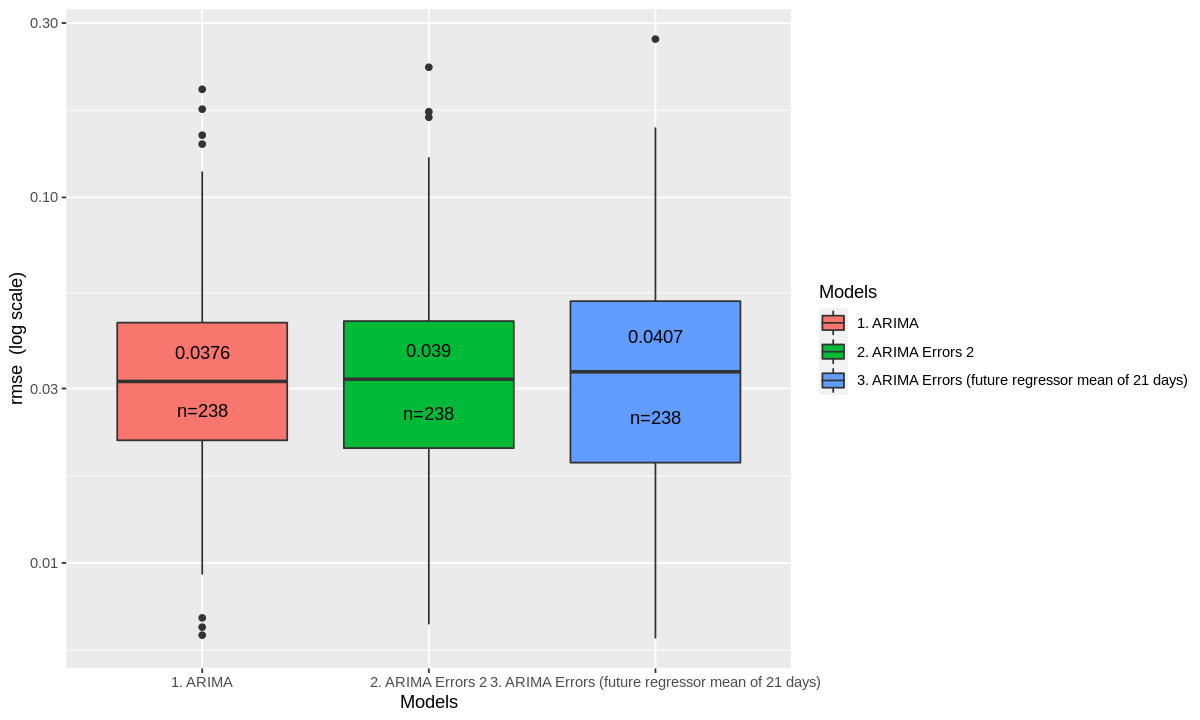

In [47]:
errors.1 <- new.get_result(result.m03.1, '1. ARIMA')
errors.2 <- new.get_result(result.m03.2, '2. ARIMA Errors 2')
n <- paste('3. ARIMA Errors (future regressor mean of', hori ,'days)', sep=' ')
errors.3 <- new.get_result(result.m03.3, n)

x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)

new.plot_errors(x, ylog=T)

### save result

In [48]:
x <- result.m03.1
write.csv(x, file = "arima_result_m0301.csv")
x <- result.m03.2
write.csv(x, file = "arima_result_m0302.csv")
x <- result.m03.3
write.csv(x, file = "arima_result_m0303.csv")

### load result

In [25]:
result.m03.1 <- read.csv(file = 'arima_result_m0301.csv')
result.m03.2 <- read.csv(file = 'arima_result_m0302.csv')
result.m03.3 <- read.csv(file = 'arima_result_m0303.csv')

In [76]:
result.m03 <- result.m03.1

# ARIMA+GARCH

## Setting

In [29]:
cv.forecast <- function(x, h, 
                        mxreg=NULL, mxreg.msize=NULL, 
                        vxreg=NULL, vxreg.msize=NULL,
                        order=NULL) {
    forc <- ag2.forecast(x, h, 
                         mxreg=mxreg, mxreg.msize=mxreg.msize, 
                         vxreg=vxreg, vxreg.msize=vxreg.msize, 
                         out.sample=0, order=order)
    if (!is.na(forc)) {
        fc <- list(method = "ARIMA+GARCH Forecasting", mean=forc@forecast$seriesFor[,1],
                   arima.order=forc@users$arima.order)
        attr(fc$mean, "names") <- NULL
        return(fc)
    }
}

agarch.forecast <- cv.forecast

In [50]:
cv.forecast.2 <- function(x, h, ...) {
    new.forecast(x, h, cv.forecast, ...)
}

## Basic

In [51]:
result.m04.1 <- my.tsCV(train, cv.forecast.2, h=hori, window=wind, step=peri,
                        silent=F)

10 % done.



[1] "GARCH model does not converge"


20 % done.

30 % done.



Error in seq.int(r1$year, by = by, length.out = length.out) : 
  'from' must be a finite number


40 % done.



[1] "GARCH model does not converge"


50 % done.

60 % done.

70 % done.



[1] "GARCH model does not converge"


80 % done.



[1] "GARCH model does not converge"


90 % done.



[1] "GARCH model does not converge"
[1] "GARCH model does not converge"


## Regressors for mean

In [52]:
result.m04.2 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        mxreg=trainx[,2:4], silent=F)

10 % done.

20 % done.

30 % done.



Error in seq.int(r1$year, by = by, length.out = length.out) : 
  'from' must be a finite number


40 % done.



[1] "GARCH model does not converge"


50 % done.

60 % done.

70 % done.

80 % done.

90 % done.



## Regressors for variance

In [53]:
result.m04.3 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        vxreg=trainx[,2:4], silent=F)

10 % done.



[1] "GARCH model does not converge"


20 % done.

30 % done.



Error in seq.int(r1$year, by = by, length.out = length.out) : 
  'from' must be a finite number


40 % done.

50 % done.



[1] "GARCH model does not converge"


60 % done.

70 % done.



[1] "GARCH model does not converge"


80 % done.



[1] "GARCH model does not converge"


90 % done.



## Regressors for both of mean & variance

In [54]:
result.m04.4 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        mxreg=trainx[,2:4], vxreg=trainx[,2:4], 
                        silent=F)

10 % done.

20 % done.

30 % done.



[1] "GARCH model does not converge"
Error in seq.int(r1$year, by = by, length.out = length.out) : 
  'from' must be a finite number


40 % done.

50 % done.

60 % done.

70 % done.

80 % done.

90 % done.



In [55]:
x <- result.m04.4
from <- x[!is.na(x[,'forecast_start']),][,1][1]
from <- index(trainx[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-02-09"


## Compare Errors

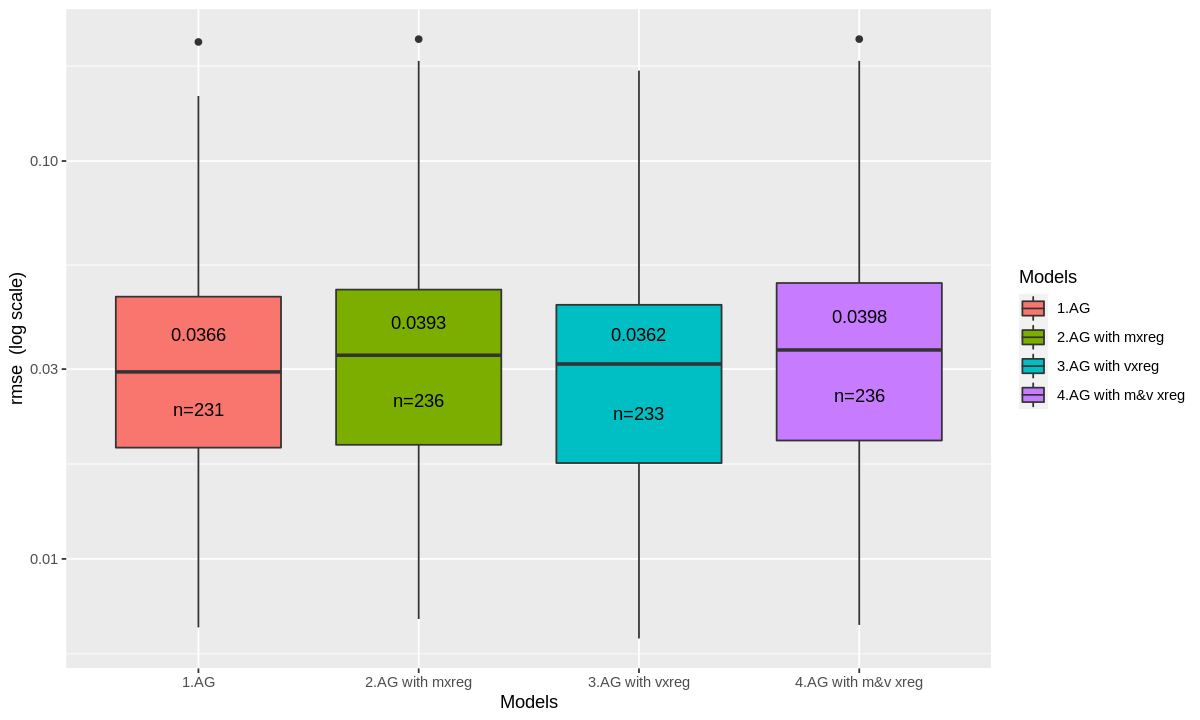

In [56]:
errors.1 <- new.get_result(result.m04.1, '1.AG')
errors.2 <- new.get_result(result.m04.2, '2.AG with mxreg')
errors.3 <- new.get_result(result.m04.3, '3.AG with vxreg')
errors.4 <- new.get_result(result.m04.4, '4.AG with m&v xreg')

x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)
x <- rbind(x, errors.4)

new.plot_errors(x, ylog=T)

### save result

In [57]:
x <- result.m04.1
write.csv(x, file = "agarch_result_m0401.csv")
x <- result.m04.2
write.csv(x, file = "agarch_result_m0402.csv")
x <- result.m04.3
write.csv(x, file = "agarch_result_m0403.csv")
x <- result.m04.4
write.csv(x, file = "agarch_result_m0404.csv")

### load result

In [28]:
result.m04.1 <- read.csv(file = 'agarch_result_m0401.csv')
result.m04.2 <- read.csv(file = 'agarch_result_m0402.csv')
result.m04.3 <- read.csv(file = 'agarch_result_m0403.csv')
result.m04.4 <- read.csv(file = 'agarch_result_m0404.csv')

In [77]:
result.m04 <- result.m04.3

# Gradient Boosting

## Setting

In [23]:
source(paste(path, "myxgb.r", sep='/'))

### set label & features

In [24]:
train.ml <- merge(lag.xts(trainx$y, -lookahead), trainx, join='left', fill=NA)
colnames(train.ml) <- c('logret_fwd', 'logret', 'rsi','bbands','macd')
train.ml <- na.omit(train.ml)

x <- head(train.ml, lookahead+6)
head(x)
tail(x)
#tail(train.ml)

idx.label <- 1
idx.feautres <- 2:5

             logret_fwd     logret      rsi    bbands        macd
1991-02-19 -0.003987479 0.10602550 72.59254 0.8419486 -0.03641515
1991-02-20  0.003935860 0.09798126 66.25313 0.7706927 -0.18551057
1991-02-21  0.006853764 0.10585688 66.00481 0.7330987 -0.30953562
1991-02-22  0.011366830 0.10194779 66.54491 0.7402938 -0.39546732
1991-02-25  0.024316594 0.09259647 67.84742 0.7305630 -0.43573971
1991-02-26  0.033979664 0.07655978 60.80133 0.6379610 -0.55105032

            logret_fwd       logret      rsi    bbands       macd
1991-03-20 0.043297723 -0.003987479 52.32729 0.2955472 -0.5878001
1991-03-21 0.038451421  0.003935860 50.29479 0.3135024 -0.6182388
1991-03-22 0.038123240  0.006853764 51.65309 0.2490278 -0.6049896
1991-03-25 0.034364782  0.011366830 55.10298 0.4057512 -0.5386086
1991-03-26 0.007808953  0.024316594 62.94322 0.6945332 -0.3702197
1991-03-27 0.009730005  0.033979664 61.25189 0.8281562 -0.2741769

## Default

In [60]:
result.m05.1 <- xgb.tsCV.mean(train.ml[,idx.label], train.ml[,idx.feautres], 
                              h=1, window=wind, step=peri)

[1] "10 % done."
[1] "20 % done."
[1] "30 % done."
[1] "40 % done."
[1] "50 % done."
[1] "61 % done."
[1] "71 % done."
[1] "81 % done."
[1] "91 % done."


In [61]:
x <- result.m05.1
from <- x[!is.na(x[,'forecast_start']),][,1][1]
from <- index(trainx[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-02-09"


## Tuning params

In [26]:
#max_depth <- seq(4, 8, 1)
#eta <- c(0.01, 0.05, 0.1, 0.2, 0.3)

max_depth <- seq(4, 8, 1)
eta <- c(0.01, 0.05, 0.1, 0.2, 0.3)

x <- expand.grid(max_depth = max_depth, eta = eta)
nrow(x)

[1] 25

In [27]:
result.m05.2 <- xgb.tsCV.mean(train.ml[,idx.label], train.ml[,idx.feautres], 
                              h=1, window=wind, step=peri,
                              max_depth = max_depth, eta = eta)

   max_depth eta
21         4 0.3
   max_depth eta
11         4 0.1
   max_depth eta
15         8 0.1
   max_depth eta
21         4 0.3
  max_depth  eta
1         4 0.01
  max_depth  eta
5         8 0.01
   max_depth eta
18         6 0.2
   max_depth eta
18         6 0.2
  max_depth  eta
1         4 0.01
   max_depth eta
23         6 0.3
  max_depth  eta
9         7 0.05
  max_depth  eta
4         7 0.01
   max_depth eta
21         4 0.3
  max_depth  eta
4         7 0.01
  max_depth  eta
2         5 0.01
   max_depth eta
23         6 0.3
  max_depth  eta
8         6 0.05
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
   max_depth eta
22         5 0.3
  max_depth  eta
4         7 0.01
   max_depth  eta
10         8 0.05
  max_depth  eta
2         5 0.01
   max_depth eta
11         4 0.1


10 % done.



   max_depth eta
14         7 0.1
  max_depth  eta
5         8 0.01
   max_depth eta
21         4 0.3
  max_depth  eta
1         4 0.01
   max_depth eta
25         8 0.3
   max_depth  eta
10         8 0.05
   max_depth eta
25         8 0.3
   max_depth eta
16         4 0.2
  max_depth  eta
2         5 0.01
   max_depth eta
22         5 0.3
  max_depth  eta
5         8 0.01
  max_depth  eta
2         5 0.01
  max_depth  eta
2         5 0.01
  max_depth  eta
9         7 0.05
  max_depth  eta
8         6 0.05
  max_depth  eta
3         6 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
   max_depth eta
19         7 0.2
  max_depth  eta
3         6 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
6         4 0.05
   max_depth eta
15         8 0.1


20 % done.



  max_depth  eta
1         4 0.01
   max_depth eta
13         6 0.1
  max_depth  eta
1         4 0.01
  max_depth  eta
3         6 0.01
  max_depth  eta
2         5 0.01
   max_depth eta
25         8 0.3
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
3         6 0.01
   max_depth eta
24         7 0.3
  max_depth  eta
2         5 0.01
  max_depth  eta
4         7 0.01
  max_depth  eta
2         5 0.01
   max_depth eta
13         6 0.1
  max_depth  eta
1         4 0.01
   max_depth eta
16         4 0.2
  max_depth  eta
3         6 0.01
   max_depth  eta
10         8 0.05
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
2         5 0.01
   max_depth eta
25         8 0.3
  max_depth  eta
1         4 0.01
  max_depth  eta
4         7 0.01


30 % done.



  max_depth  eta
6         4 0.05
  max_depth  eta
1         4 0.01
  max_depth  eta
2         5 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
3         6 0.01
  max_depth  eta
9         7 0.05
  max_depth  eta
1         4 0.01
   max_depth eta
20         8 0.2
   max_depth eta
23         6 0.3
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
5         8 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
3         6 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
6         4 0.05
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
   max_depth eta
25         8 0.3
  max_depth  eta
3         6 0.01
  max_depth  eta
3         6 0.01
   max_depth eta
22         5 0.3


40 % done.



  max_depth  eta
3         6 0.01
  max_depth  eta
5         8 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
5         8 0.01
   max_depth eta
16         4 0.2
  max_depth  eta
1         4 0.01
  max_depth  eta
4         7 0.01
   max_depth eta
21         4 0.3
  max_depth  eta
5         8 0.01
   max_depth eta
25         8 0.3
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
   max_depth eta
12         5 0.1
   max_depth eta
21         4 0.3
   max_depth  eta
10         8 0.05
   max_depth eta
20         8 0.2
  max_depth  eta
3         6 0.01
   max_depth eta
20         8 0.2
   max_depth eta
15         8 0.1
   max_depth eta
23         6 0.3
  max_depth  eta
1         4 0.01
   max_depth eta
24         7 0.3
   max_depth eta
23         6 0.3
   max_depth eta
19         7 0.2


50 % done.



   max_depth eta
13         6 0.1
   max_depth eta
21         4 0.3
  max_depth  eta
2         5 0.01
  max_depth  eta
2         5 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
3         6 0.01
  max_depth  eta
2         5 0.01
   max_depth eta
23         6 0.3
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
   max_depth eta
20         8 0.2
  max_depth  eta
1         4 0.01
   max_depth eta
13         6 0.1
  max_depth  eta
5         8 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
   max_depth eta
24         7 0.3
   max_depth eta
14         7 0.1
   max_depth eta
15         8 0.1
  max_depth  eta
8         6 0.05
   max_depth eta
16         4 0.2
  max_depth  eta
6         4 0.05
   max_depth eta
22         5 0.3
   max_depth eta
25         8 0.3


61 % done.



  max_depth  eta
1         4 0.01
  max_depth  eta
5         8 0.01
  max_depth  eta
9         7 0.05
   max_depth eta
11         4 0.1
  max_depth  eta
9         7 0.05
  max_depth  eta
1         4 0.01
   max_depth eta
16         4 0.2
  max_depth  eta
6         4 0.05
   max_depth eta
25         8 0.3
   max_depth eta
12         5 0.1
  max_depth  eta
7         5 0.05
   max_depth eta
17         5 0.2
  max_depth  eta
1         4 0.01
  max_depth  eta
5         8 0.01
   max_depth eta
14         7 0.1
   max_depth  eta
10         8 0.05
  max_depth  eta
1         4 0.01
  max_depth  eta
4         7 0.01
  max_depth  eta
4         7 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
   max_depth eta
20         8 0.2
   max_depth eta
25         8 0.3


71 % done.



  max_depth  eta
9         7 0.05
  max_depth  eta
2         5 0.01
  max_depth  eta
2         5 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
5         8 0.01
  max_depth  eta
3         6 0.01
  max_depth  eta
4         7 0.01
  max_depth  eta
3         6 0.01
   max_depth eta
14         7 0.1
  max_depth  eta
1         4 0.01
  max_depth  eta
5         8 0.01
  max_depth  eta
2         5 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
3         6 0.01
  max_depth  eta
3         6 0.01
   max_depth eta
19         7 0.2
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
2         5 0.01
   max_depth eta
20         8 0.2


81 % done.



  max_depth  eta
5         8 0.01
  max_depth  eta
3         6 0.01
  max_depth  eta
3         6 0.01
  max_depth  eta
4         7 0.01
  max_depth  eta
1         4 0.01
   max_depth eta
19         7 0.2
  max_depth  eta
1         4 0.01
  max_depth  eta
2         5 0.01
  max_depth  eta
3         6 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
2         5 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
4         7 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
4         7 0.01
  max_depth  eta
1         4 0.01
  max_depth  eta
3         6 0.01
   max_depth eta
18         6 0.2
  max_depth  eta
1         4 0.01
   max_depth eta
23         6 0.3
   max_depth eta
25         8 0.3
   max_depth eta
24         7 0.3


91 % done.



   max_depth eta
17         5 0.2
  max_depth  eta
8         6 0.05
  max_depth  eta
1         4 0.01
  max_depth  eta
4         7 0.01
  max_depth  eta
1         4 0.01
   max_depth eta
23         6 0.3
   max_depth eta
23         6 0.3
  max_depth  eta
1         4 0.01
   max_depth eta
15         8 0.1
   max_depth eta
14         7 0.1
  max_depth  eta
1         4 0.01
   max_depth eta
22         5 0.3
   max_depth eta
21         4 0.3
  max_depth  eta
1         4 0.01
   max_depth eta
17         5 0.2
   max_depth eta
23         6 0.3
  max_depth  eta
3         6 0.01
  max_depth  eta
2         5 0.01
   max_depth eta
18         6 0.2
  max_depth  eta
2         5 0.01
   max_depth eta
12         5 0.1
   max_depth eta
19         7 0.2


## Compare Models

In [28]:
my.figsize(10,6)

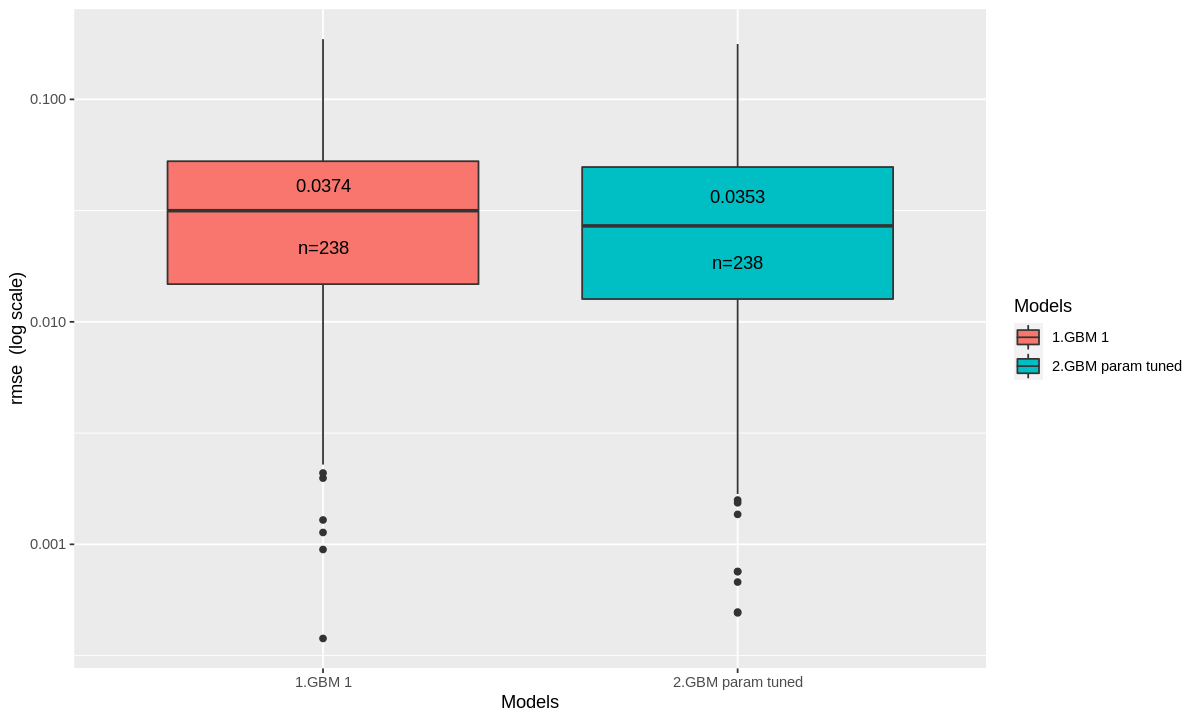

In [29]:
errors.1 <- new.get_result(result.m05.1, '1.GBM 1')
errors.2 <- new.get_result(result.m05.2, '2.GBM param tuned')

x <- errors.1
x <- rbind(x, errors.2)

new.plot_errors(x, ylog=T)

### save result

In [30]:
#x <- result.m05.1
#write.csv(x, file = "gbm_result_m0501.csv")
x <- result.m05.2
write.csv(x, file = "gbm_result_m0502.csv")

### load result

In [25]:
result.m05.1 <- read.csv(file = 'gbm_result_m0501.csv')
#result.m05.2 <- read.csv(file = 'gbm_result_m0502.csv')

In [78]:
result.m05 <- result.m05.2

# Model Comparision

## Compare RMSE

In [31]:
result.m01 <- read.csv(file = 'prophet_result_m0102.csv')
result.m02 <- read.csv(file = 'bsts_result_m0201.csv')
result.m03 <- read.csv(file = 'arima_result_m0301.csv')
result.m04 <- read.csv(file = 'agarch_result_m0403.csv')
result.m05 <- read.csv(file = 'gbm_result_m0502.csv')

In [32]:
errors.1 <- new.get_result(result.m01, '1. Prophet')
errors.2 <- new.get_result(result.m02, '2. BSTS')
errors.3 <- new.get_result(result.m03, '3. ARIMA')
errors.4 <- new.get_result(result.m04, '4. ARIMA+GARCH')
errors.5 <- new.get_result(result.m05, '5. Gradient Boosting')

In [33]:
errors.list <- list(errors.1, errors.2, errors.3, errors.4, errors.5)
x <- errors.list[[1]]
for (e in errors.list[2:length(errors.list)]) {
    x <- rbind(x, e)
}

In [34]:
# read data from file
x <- read.csv(file = 'result_comparison.csv')

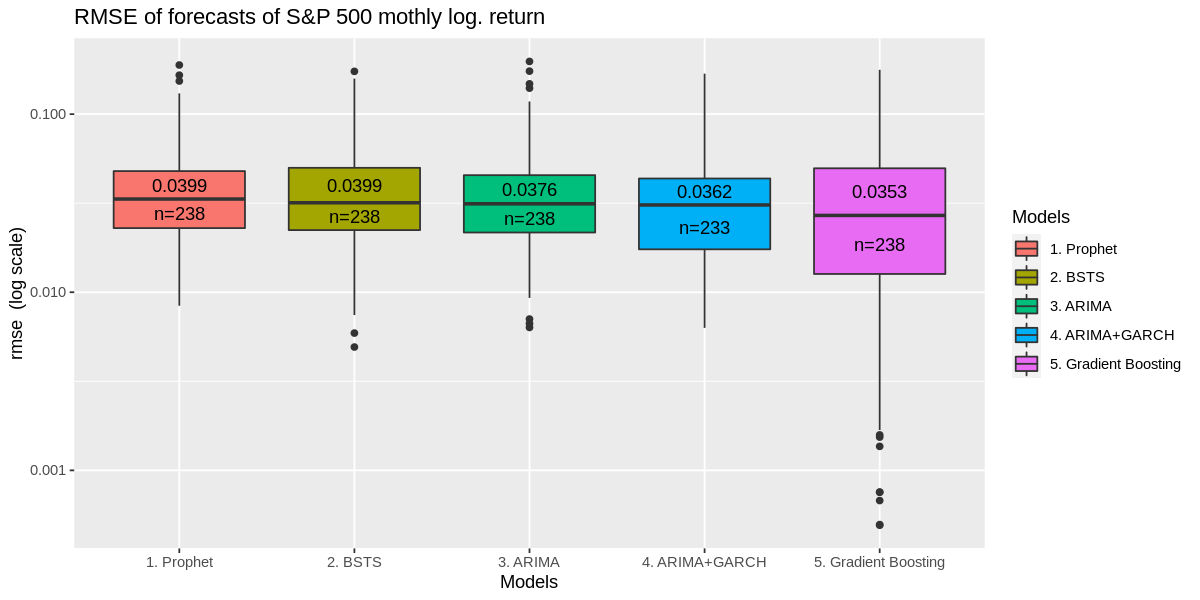

In [34]:
my.figsize(10, 5)
g <- new.plot_errors(x, ylog=T)
g + ggtitle("RMSE of forecasts of S&P 500 mothly log. return ")

In [28]:
x <- abs(train)
mean(x)
median(x)

[1] 0.03244951

[1] 0.02545506

In [35]:
write.csv(x, file = "result_comparison.csv")

In [7]:
# testing

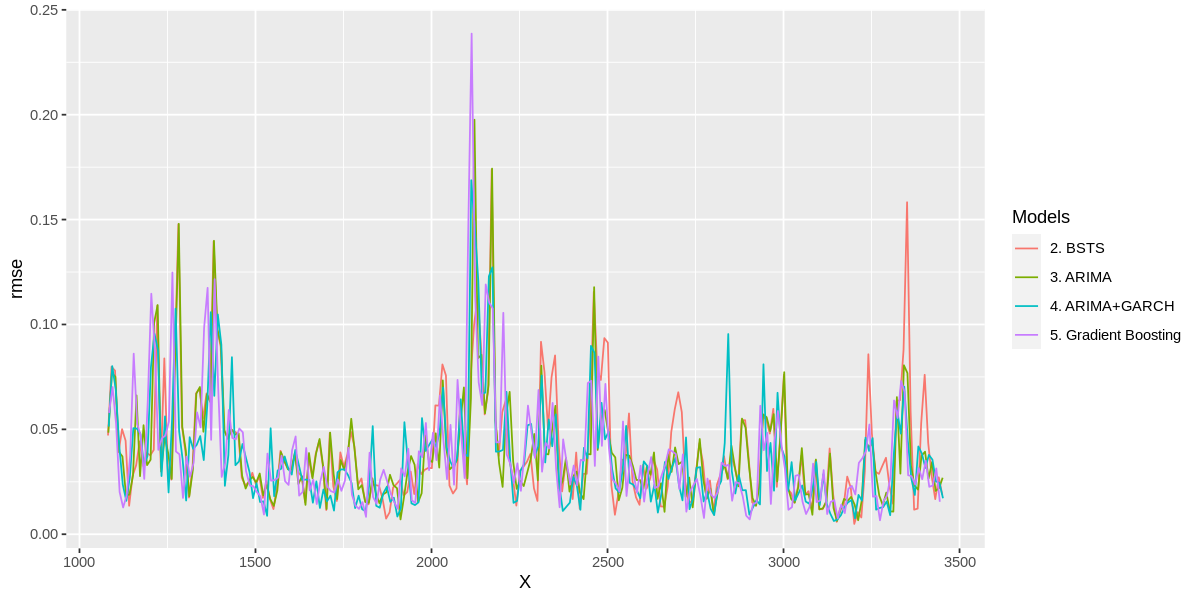

In [41]:
#y <- x
y <- x[x$Models != '1. Prophet',]
(ggplot(y, aes(x=X, y=rmse, color=Models)) 
 + geom_line()
 #+ geom_point()
)

## Forecast with best model

### Dataset

In [ ]:
lookahead <- 21

In [182]:
set.seed(1)
#set.seed(NULL)

h <- 21

# idx works for gbm as well
idx <- wind:(nrow(trainx)-wind-h-lookahead)
idx <- sample(idx, 1)

idx.train <- idx:(idx+wind-1)
idx.test <- (idx+wind):(idx+wind+h-1)

In [139]:
x.train <- trainx[idx.train]
x.test <- trainx[idx.test]

x.train.r <- x.train[,1]
x.train.xr <- x.train[,2:4]
x.test.r <- x.test[,1]

### ARIMA+GARCH

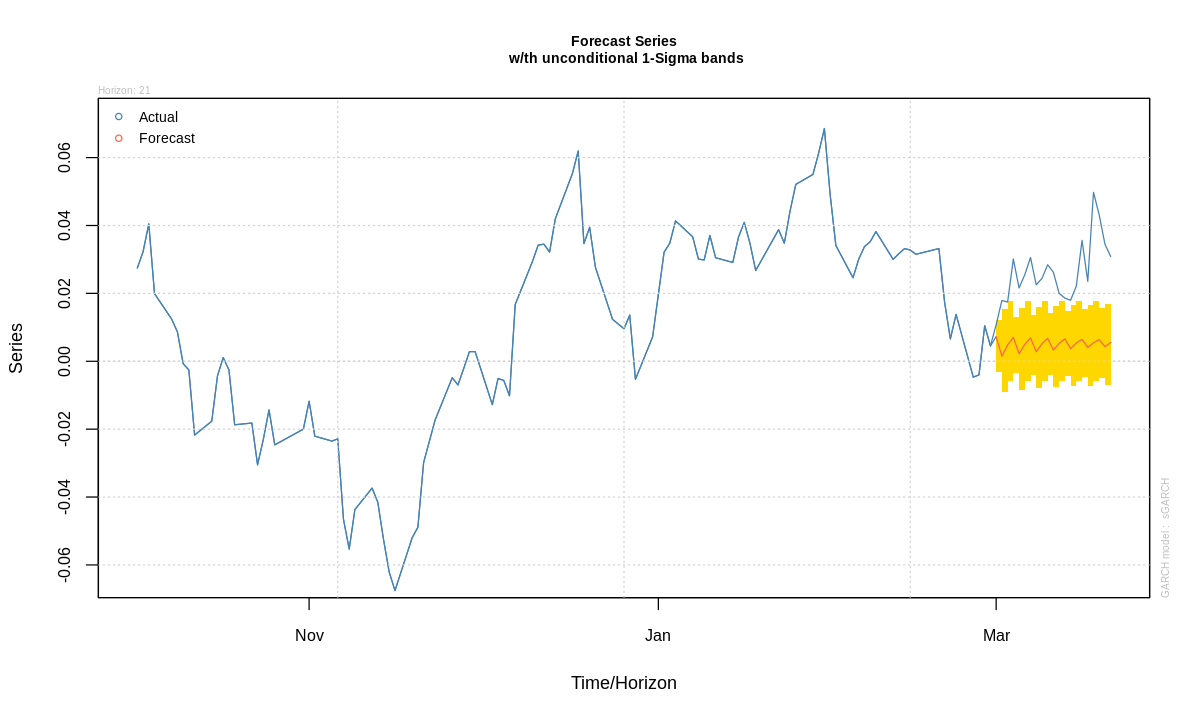

In [151]:
fc <- ag2.forecast(x.train.r, h, vxreg=x.train.xr)
ag2.plot(fc, figsize=c(10,6), test=x.test.r) 

### ARIMA


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -11546.54
 ARIMA(0,0,0) with non-zero mean : -7110.071
 ARIMA(1,0,0) with non-zero mean : -11509.39
 ARIMA(0,0,1) with non-zero mean : -9074.031
 ARIMA(0,0,0) with zero mean     : -7106.064
 ARIMA(1,0,2) with non-zero mean : -11542.62
 ARIMA(2,0,1) with non-zero mean : -11541.07
 ARIMA(3,0,2) with non-zero mean : -11612.69
 ARIMA(3,0,1) with non-zero mean : -11552.61
 ARIMA(4,0,2) with non-zero mean : -11564.03
 ARIMA(3,0,3) with non-zero mean : Inf
 ARIMA(2,0,3) with non-zero mean : -11558.44
 ARIMA(4,0,1) with non-zero mean : -11560.04
 ARIMA(4,0,3) with non-zero mean : Inf
 ARIMA(3,0,2) with zero mean     : -11620.27
 ARIMA(2,0,2) with zero mean     : -11548.39
 ARIMA(3,0,1) with zero mean     : -11554.45
 ARIMA(4,0,2) with zero mean     : Inf
 ARIMA(3,0,3) with zero mean     : Inf
 ARIMA(2,0,1) with zero mean     : -11542.93
 ARIMA(2,0,3) with zero mean     : -11560.27
 ARIMA(4,0,1) with

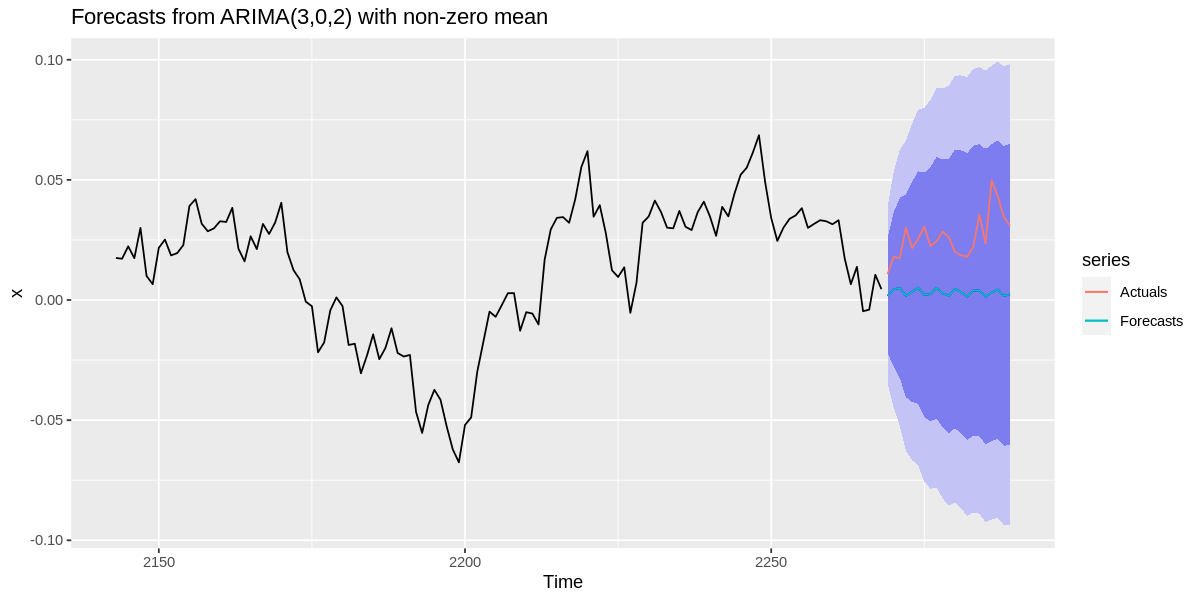

In [121]:
my.figsize(10,5)
fc <- arima.forecast(x.train.r, h)
my.plot_forecast(fc, future=h, test=x.test.r, past=h*6)

### BSTS

In [122]:
bsts.lines <- function(fc, obs, ...) {
    n1 <- ncol(fc$distribution)
    time <- index(fc$original.series)
    deltat <- tail(diff(tail(time, 2)), 1)
    pred.time <- tail(time, 1) + (1:n1) * deltat
    obs <- obs[1:length(pred.time)]
    index(obs) <- pred.time
    #l <- lines(obs)
    l <- lines(pred.time, as.numeric(obs), ...)
    return(l)
}

fc <- bsts.forecast(x.train.r, h, ping=0)

NULL

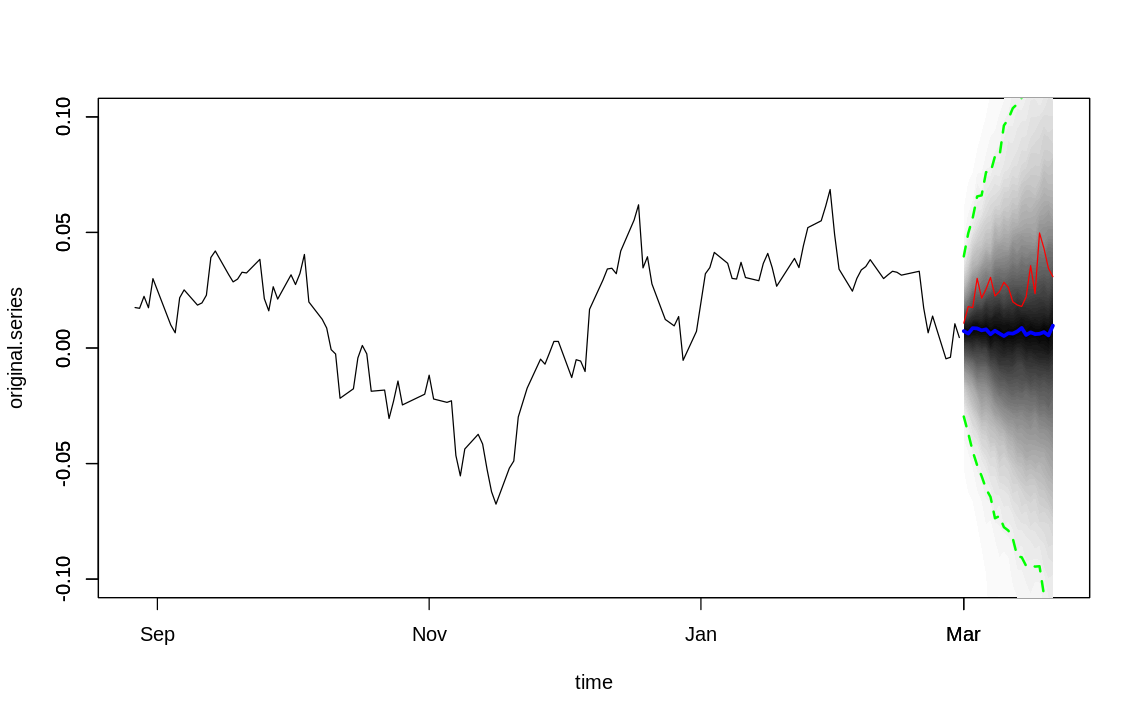

In [131]:
my.figsize(9.5,6)
plot(fc, plot.original=h*6, ylim=c(-0.1, 0.1))
bsts.lines(fc, x.test.r, col='red')

### GBM

In [210]:
h.gbm <- 1
#h.gbm <- h

train.ml <- merge(lag.xts(trainx$y, -lookahead), trainx, join='left', fill=NA)
colnames(train.ml) <- c('logret_fwd', 'logret', 'rsi','bbands','macd')
idx.label <- 1
idx.feautres <- 2:5

x.train.ml <- train.ml[idx.train]
x.test.ml <- train.ml[idx.test[1:h.gbm]]

x.train.label <- x.train.ml[,idx.label]
x.train.features <- x.train.ml[,idx.feautres]
x.test.label <- x.test.ml[,idx.label]
x.test.features <- x.test.ml[,idx.feautres]

In [211]:
max_depth <- seq(4, 8, 1)
eta <- c(0.01, 0.05, 0.1, 0.2, 0.3)

fc <- xgb.forecast(x.train.label, x.train.features, x.test.label, x.test.features,
                   max_depth=max_depth, eta=eta)

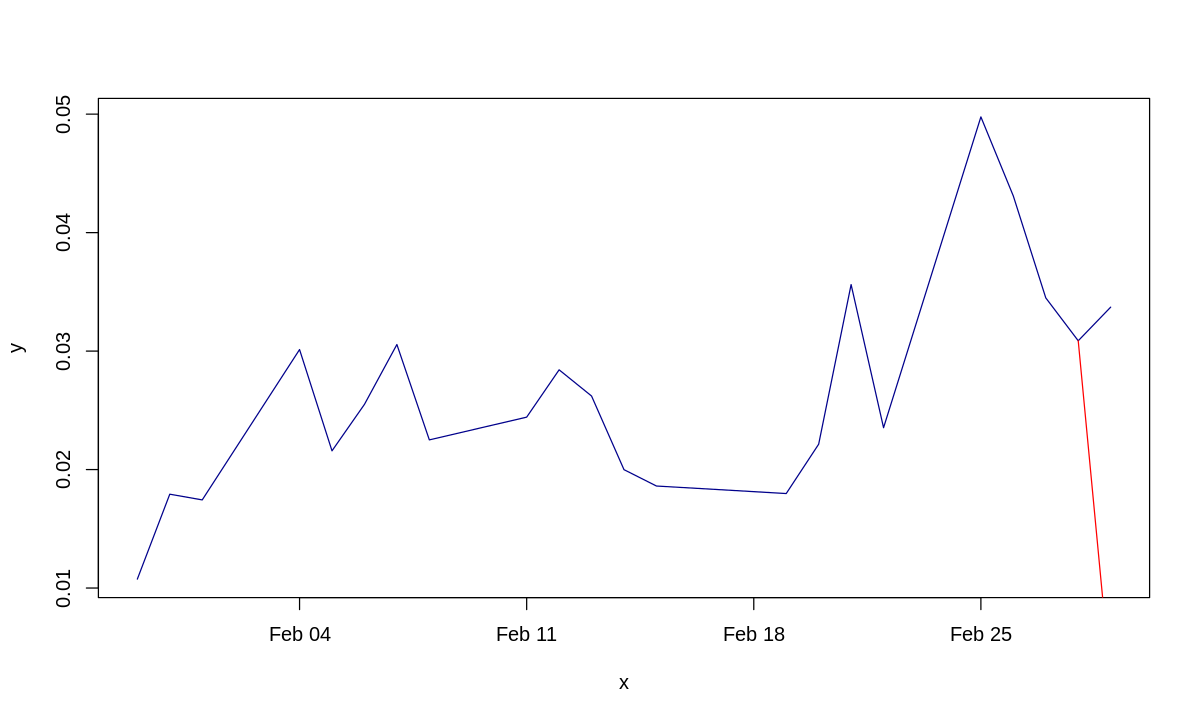

In [212]:
l <- tail(x.train.label, h*1)
x <- index(l)
x <- append(x, tail(x,1)+1:h.gbm)
y <- as.numeric(l)
y <- append(y, as.numeric(x.test.label))
plot(x, y, type='l', col='darkblue')

x <- tail(x, h.gbm+1)
y <- append(tail(as.numeric(l),1), fc$pred)
lines(x, y, col='red')

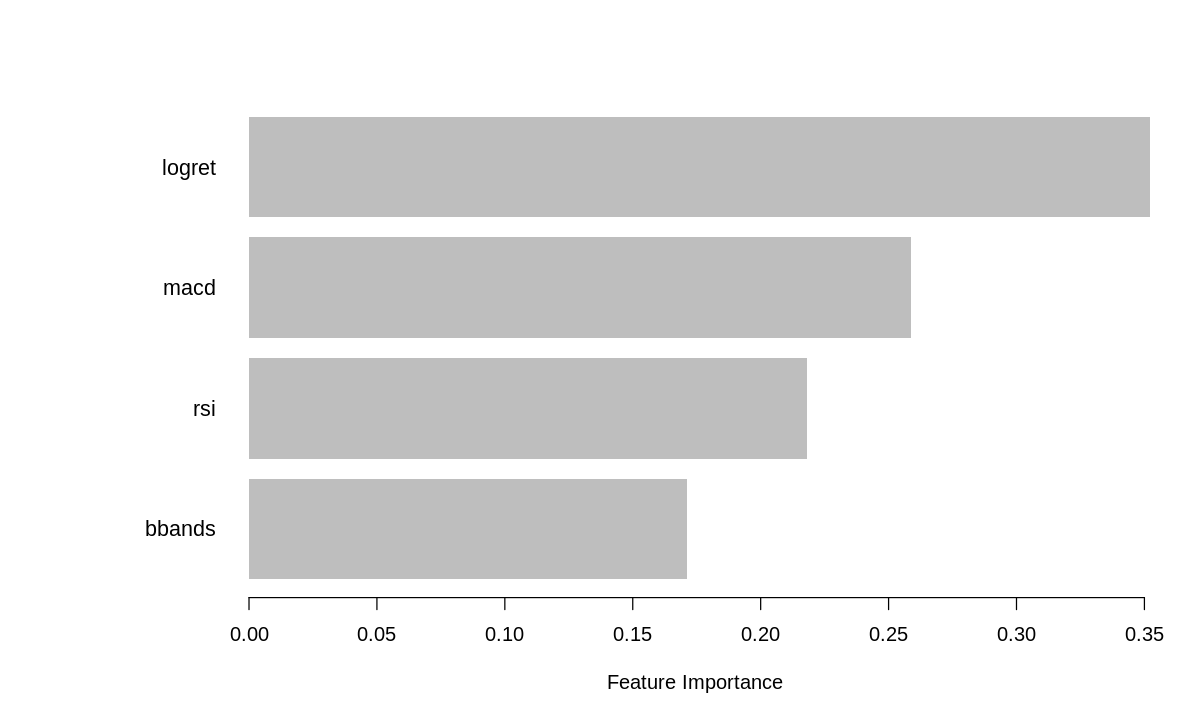

In [213]:
importance_matrix <- xgb.importance(model=fc$model)
xgb.plot.importance(importance_matrix, xlab = "Feature Importance")